In [6]:
import json 
import gzip
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# Higher precision point than float64
from decimal import Decimal, getcontext
# Set the desired precision
getcontext().prec = 50


l2_norm = lambda x: np.sqrt( np.array(x) @ np.array(x) )
linf_norm = lambda x: np.max(np.abs(x))

def open_json_file(file_name:str, file_path:str)-> dict:
    # Zipped json file
    if ".gz" in file_name:
        with gzip.open(f"{file_path}/{file_name}", "rt") as f:
            return json.load(f)
    elif ".json" in file_name:
        with open(f"{file_path}/{file_name}", "rt") as f:
            return json.load(f)
    raise ValueError("Filename must end in '.json' or '.json.gz' ")


def python_to_julia_scientific(python_number):
    if python_number <= 1e-5:
        python_string = str(python_number) 
        base, exponent = python_string.lower().split('e')
        exponent = int(exponent)  # Remove leading zeros and ensure it's an integer
        base = float(base)
        return f"{base}e{exponent:+d}"  # Format with explicit sign
    else:
        return str(python_number)


def get_house_instances_list(
        kappas:list,
        deltas:list,
        kappa_bound=True
        ) -> list:
    instance_list = []  # Output list
    # Loop the values of the combinations of kappa/delta 
    for kappa in kappas:
        for delta in deltas:
            if kappa_bound and delta > kappa:   # kappa <= delta condition
                continue
            delta = python_to_julia_scientific(delta)
            instance_list.append(f"house_k{kappa}_d{delta}") # Save the instance name
    return instance_list




def get_MIPLIB_instances_list(
        instances_path:str,
        instances_size:str,

) -> list:
        
    # Multisize version (think about this)
    # instance_list = []
    # for data_size in instances_sizes: # tiny_instances, small_instances, etc.
    #     instance_list+=os.listdir(f"{instances_path}/{data_size}")
    # return instance_list

    return os.listdir(f"{instances_path}/{instances_size}")




def plot_PDLP_instances(
        instance_list:list, # Instance names only
        output_path:str,    # Path where instance folders are available
        plot_attributes={
            "figsize":(8,6),
            "title":"cuPDLP's rel. KKT evolution",
            "y_label":"rel. KKT residual",
            "x_label":"iterations",
            "legend_position":(1.0, 1.0),
            "y_log_scale":False,
            "x_log_scale":False,
            }
        ) -> None:

    # 1. Begin the plot that will contain every instances on it
    plt.figure(figsize=plot_attributes["figsize"])

    # 2. Loop the instances of the list
    for instance_name in instance_list:

        # 2.1. Open the instance full log (every iteration)
        full_log_output = open_json_file(f"{instance_name}_k0_full_log.json.gz", f"{output_path}/{instance_name}")

        # (Skip infeasbile instances)
        if full_log_output["termination_reason"] == "TERMINATION_REASON_PRIMAL_INFEASIBLE":
            continue

        # 2.2. Get attributes from full log
        total_iterations = full_log_output['iteration_count']
        # print("Total iter of full log in ", instance_name, ": ", total_iterations)

        # 2.3. Relative KKT values, from the three possible keys: primal feas., dual feas., and p-d gap.
        kkt_keys = [
            "relative_l_inf_primal_residual", # primal feas.
            "relative_l_inf_dual_residual", # dual feas. 
            "relative_optimality_gap" # optimality gap between primal and dual (comp. slackness implicitly)
            ]
        kkt_values = []

        # 2.4. Loop the iterations to get KKT relative error
        for k in range(int(total_iterations)+1):
            final_kkt_value = 0
            for key in kkt_keys: # Loop the 3 keys
                # print(f"{key}: {output['iteration_stats'][k]['convergence_information'][0][key]}")
                # try:
                #     final_kkt_value.append(output["iteration_stats"][k]['convergence_information'][0][key])
                # except Exception as e:
                #     print("error in:",kappa,delta,k)
                #     print(e)
                #     print(len(output["iteration_stats"]))
                #     # print(len(output_2))
                #     break
                
                final_kkt_value+=full_log_output["iteration_stats"][k]['convergence_information'][0][key]**2 # KKT values of iter k

            kkt_values.append(np.sqrt(final_kkt_value)) # Apply sqrt to the squared sum

        # Plot the kkt evolution through the iterations
        k_iters = [k+1 for k in range(total_iterations+1)]
        plt.plot(k_iters, kkt_values, label=fr"{instance_name}")  #fr"($\kappa$,$\delta$)={(kappa,delta)}")



    # Plot main attributes
    plt.title(plot_attributes["title"])
    if plot_attributes["y_log_scale"]:
        plt.yscale('log')
        # plt.ylabel(f"log-{plot_attributes["y_label"]}")
        # print(plot_attributes["y_label"])
        plt.ylabel("log-{}".format(plot_attributes["y_label"]))
    else:
        plt.ylabel(plot_attributes["y_label"])
    if plot_attributes["x_log_scale"]:
        plt.xscale('log')
        plt.xlabel("log-{}".format(plot_attributes["x_label"]))
    else:
        plt.xlabel(plot_attributes["x_label"])
    plt.legend(bbox_to_anchor=plot_attributes["legend_position"], loc='upper left', borderaxespad=0)
    plt.show()

def plot_IR_instances(
    instance_list:list,     # Instance names only
    output_path:str,        # Path where instance folders are available
    ir_iterations_tolerance:float,   # IR tolerance on each iteration
    objective_tolerance:float,       # IR termination tolerance (and PDLP objective tolerance)  
    x_time_val_source:str,  # source of the time (PDLP or IR_PDLP)
    ir_scaling_colors:list, # List of colors to differenciate types of scaling
    scaling_types:list,     # List of the scaling types applied to the instances
    scaling_dict:dict,      # Dictionary of codes of scaling (for visualization purposes)
    alpha_indep_types:list, # List of the methods that are indep of alpha
    scaling_alphas:list,    # Alphas used on every scaling type
    limit_ir_iters:int,     # Max/Limit number of iterations of IR shown in the plot
    show_pdlp_iters=True,
    plot_attributes={   
        "figsize":(8,6),
        "title":"cuPDLP's rel. KKT evolution",
        "y_label":"rel. KKT residual",
        "x_label":"iterations",
        "legend_position":(1.0, 1.0),
        "y_log_scale":False,
        "x_log_scale":False,
        "y_log_values_correction":1e-12,
        "x_log_values_correction":1e-12,
        "x_lim":None,
        "y_lim":None,
        }
    ) -> None:



    # 1. Loop the instances of the list
    for instance_name in instance_list:

        # 2. Begin the plot that will contain every instances on it
        plt.figure(figsize=plot_attributes["figsize"])
        x_max_val = 0

        # 2.1. Open the instance full log (every iteration)
        try:
            full_log_output = open_json_file(f"{instance_name}_k0_full_log.json.gz", f"{output_path}/{instance_name}")
            ir_pdlp_summary_output = open_json_file(f"{instance_name}_PDLP_a0_summary.json", f"{output_path}/{instance_name}")
        except Exception as e:
            print(e)
            continue

        # (Skip infeasbile instances)
        if full_log_output["termination_reason"] == "TERMINATION_REASON_PRIMAL_INFEASIBLE":
            continue
        # print(instance_name, " termination reason: ", full_log_output["termination_reason"])

        # 2.2. Output attributes
        if show_pdlp_iters:
            total_iterations = full_log_output["iteration_count"]
            execution_time_pdlp = full_log_output["solve_time_sec"] # Direct time of PDLP 
            execution_time_ir_pdlp = ir_pdlp_summary_output['total_time'] # Non-direct time (with IR garbage time) 

            # 2.3. x axis values from iter to time
            if x_time_val_source == 'PDLP':
                x_values = np.linspace(0, execution_time_pdlp, num=total_iterations+1)+plot_attributes["x_log_values_correction"] if plot_attributes["x_log_scale"] else np.linspace(0, execution_time_pdlp, num=total_iterations+1)
            elif x_time_val_source == 'IR_PDLP':
                x_values = np.linspace(0, execution_time_ir_pdlp, num=total_iterations+1)+plot_attributes["x_log_values_correction"] if plot_attributes["x_log_scale"] else np.linspace(0, execution_time_ir_pdlp, num=total_iterations+1)

            # 2.5. KKT relative keys and values
            kkt_keys = [
                "relative_l_inf_primal_residual", # primal feas.
                "relative_l_inf_dual_residual", # dual feas. 
                "relative_optimality_gap" # optimality gap between primal and dual (comp. slackness implicitly)
                ]
            kkt_values = []

            # 2.6. Loop the iterations to get KKT relative error
            for k in range(int(total_iterations)+1):
                final_kkt_value = 0
                for key in kkt_keys: # Loop the 3 keys
                    final_kkt_value+=full_log_output["iteration_stats"][k]['convergence_information'][0][key]**2 # KKT values of iter k
                kkt_values.append(np.sqrt(final_kkt_value)) # Apply sqrt to the squared sum


            # 2.7. Plot the kkt evolution through time
            kkt_values = np.array(kkt_values)+plot_attributes["y_log_values_correction"] if plot_attributes['y_log_scale'] else np.array(kkt_values)  # Log scale correction to 0 values
            plt.plot(x_values, kkt_values, '-',label=fr"{instance_name} cuPDLP", alpha=0.7, c='C0', markersize=plot_attributes["markersize"])

            x_max_val = max(x_max_val, np.max(x_values)) #(update x max val)
            x_min_val = 0
        else:
            x_max_val = 0
            x_min_val = float("inf")

        # 3. Loop the scaling types 
        color_index = 0 
        for scaling_type in scaling_types:
            # 3.1 Loop the alphas used on the the scaling types
            for alpha in scaling_alphas: 

                # (Skip the alpha indep methods on 2nd iter of alphas)
                if scaling_type in alpha_indep_types and alpha != scaling_alphas[0]:
                    continue
                elif scaling_type in alpha_indep_types:
                    alpha = 0

                # 3.2 Open the scaling applied to the instance
                try:
                    ir_scaling_summary_output = open_json_file(f"{instance_name}_{scaling_dict[scaling_type]}_a{alpha}_summary.json", f"{output_path}/{instance_name}")
                    ir_total_iters = ir_scaling_summary_output["last_iteration"]   # Total iterations of IR with scaling method
                except Exception as e:
                    print(e)
                    continue


                color_index+=1 # update color index for the list of colors

                # 3.3 KKT info
                kkt_keys = [
                    "relative_l_inf_primal_residual", # primal feas.
                    "relative_l_inf_dual_residual", # dual feas. 
                    "relative_optimality_gap" # optimality gap between primal and dual (comp. slackness implicitly)
                    ]

                # 3.4 KKT and iter info of IR to be added to plot
                x_vals = []
                y_vals = []
                start_time_IR = 0#corr_to_x

                x_max_sub_val = 0
                x_min_sub_val = float("inf")

                # 3.5 Loop the iterations of IR to save info
                for i in range(ir_total_iters+1):
                    kkt_values = np.array([ # array with 3 keys KKT
                        ir_scaling_summary_output[kkt_keys[0]][i],
                        ir_scaling_summary_output[kkt_keys[1]][i],
                        ir_scaling_summary_output[kkt_keys[2]][i]
                        ])
                    kkt_value = linf_norm(kkt_values)+plot_attributes["y_log_values_correction"] if plot_attributes["y_log_scale"] else linf_norm(kkt_values) # Correction for log KKT values if 0
                    start_time_IR+=ir_scaling_summary_output['blackbox_time'][i]   # Addig time of each instance to the total     
                    x_value = start_time_IR+plot_attributes["x_log_values_correction"] if plot_attributes["x_log_scale"] else start_time_IR
                    x_vals.append(x_value)          # Save times for x axis
                    y_vals.append(kkt_value)        # Save rel. KKT vallues for y axis

                    if x_value >= x_max_sub_val: # update max val
                        x_max_sub_val = x_value
                    if x_value <= x_min_sub_val:
                        x_min_sub_val = x_value

                    # 3.5.2 Limit on the iterations of IR to be shown
                    if i >= limit_ir_iters:
                        break

                if x_max_sub_val >= x_max_val: # update max val
                    x_max_val = x_max_sub_val

                if not show_pdlp_iters:
                    if x_min_val >= x_min_sub_val:
                        x_min_val = x_min_sub_val
                
                # if len(x_vals) > 0:
                if scaling_type in alpha_indep_types:
                    plt.plot(x_vals, y_vals, '-x',label=fr"$\alpha$ indep. - {scaling_dict[scaling_type]}", color=ir_scaling_colors[color_index], markersize=plot_attributes["markersize"]) # -x
                else:
                    plt.plot(x_vals, y_vals, '-x',label=fr"$\alpha$={alpha} - {scaling_dict[scaling_type]}", color=ir_scaling_colors[color_index], markersize=plot_attributes["markersize"]) # -x



        # Add objective and IR tolerances on the plot as lines
        if show_pdlp_iters:
            x_line_lims = [plot_attributes["x_log_values_correction"], x_max_val] if plot_attributes["y_log_scale"] else [0, x_max_val]
        else:
            x_line_lims = [x_min_val + plot_attributes["x_log_values_correction"], x_max_val] if plot_attributes["y_log_scale"] else [x_min_val, x_max_val]
        plt.plot(x_line_lims, [ir_iterations_tolerance, ir_iterations_tolerance], '--', color="black", alpha=0.7, label="IR iters. tol")
        plt.plot(x_line_lims, [objective_tolerance, objective_tolerance], '--', color="black", alpha=0.7, label="Objective tol")

        # 4. Plot main attributes
        plt.title("{} - {}".format(plot_attributes["title"], instance_name))
        if plot_attributes["y_log_scale"]:
            plt.yscale('log')
            plt.ylabel("log-{}".format(plot_attributes["y_label"]))
        else:
            plt.ylabel(plot_attributes["y_label"])
        if plot_attributes["x_log_scale"]:
            plt.xscale('log')
            plt.xlabel("log-{}".format(plot_attributes["x_label"]))
        else:
            plt.xlabel(plot_attributes["x_label"])
        if plot_attributes["x_lim"] != None:
            plt.xlim(plot_attributes["x_lim"])
        if plot_attributes["y_lim"] != None:
            plt.ylim(plot_attributes["y_lim"])
        plt.legend(bbox_to_anchor=plot_attributes["legend_position"], loc='upper left', borderaxespad=0)
        plt.show()

def get_intance_comparisson_table(
        instance_list:list, # Instance names only
        output_path:str,    # Path where instance folders are available
        table_value_type:str,        # time, kkt
        time_val_source:str,  # source of the time of original problem (PDLP or IR_PDLP)
        scaling_types:list,     # List of the scaling types applied to the instances
        scaling_dict:dict,      # Dictionary of codes of scaling (for visualization purposes)
        alpha_indep_types:list, # List of the methods that are indep of alpha
        scaling_alphas:list,    # Alphas used on every scaling type
        max_iter=1000,           # Max iterations imposed on the method
        time_limit=600,
        ):
    

    # Dataframe columns
    df_cols = ["Instance", "cuPDLP"] 
    df_rows = []

    # 0. Loop the instances of the list
    for instance_name in instance_list:

        # 0.1 Create df row
        df_row = [instance_name]

        # 2. Begin the plot that will contain every instances on it
        # plt.figure(figsize=plot_attributes["figsize"])
        # x_max_val = 0

        # 1. Open the instance original resolution time and termination reason
        try:
            full_log_output = open_json_file(f"{instance_name}_k0_full_log.json.gz", f"{output_path}/{instance_name}")
            ir_pdlp_summary_output = open_json_file(f"{instance_name}_PDLP_a0_summary.json", f"{output_path}/{instance_name}")
        except Exception as e:
            print(e)
            continue

        # (Skip infeasbile instances)
        if full_log_output["termination_reason"] == "TERMINATION_REASON_PRIMAL_INFEASIBLE":
            continue
        # print(instance_name, " termination reason: ", full_log_output["termination_reason"])

        # 2. Choose the value for the table
        if table_value_type == "time":
            # total_iterations = full_log_output["iteration_count"]
            if time_val_source == "PDLP":
                original_table_value = full_log_output["solve_time_sec"] # Direct time of PDLP 
            elif time_val_source == "IR_PDLP":
                original_table_value = ir_pdlp_summary_output['total_time'] # Non-direct time (with IR garbage time) 
        elif table_value_type == "kkt":
            kkt_keys = [
                "relative_l_inf_primal_residual", # primal feas.
                "relative_l_inf_dual_residual", # dual feas. 
                "relative_optimality_gap" # optimality gap between primal and dual (comp. slackness implicitly)
                ]
            # kkt_value = 0
            kkt_values = []
            for key in kkt_keys:
                # kkt_value+= full_log_output["iteration_stats"][-1]['convergence_information'][0][key]**2
                kkt_values.append(ir_pdlp_summary_output[key][-1])
            original_table_value = linf_norm(kkt_values)

        # 3. Update the original table value
        df_row.append(original_table_value)
    
        # 3. Loop the scaling types 
        for scaling_type in scaling_types:

            # 3.1 Loop the alphas used on the the scaling types
            for alpha in scaling_alphas: 

                # (Skip the alpha indep methods on 2nd iter of alphas)
                if scaling_type in alpha_indep_types:
                    if alpha != scaling_alphas[0]:
                        # print("Breaking")
                        # print("alpha:", alpha)
                        break
                    elif fr"{scaling_dict[scaling_type]} a-indep." not in df_cols:
                        # print("Nonbreakinh")
                        # print("Changing to alpha=0")
                        df_cols += [fr"{scaling_dict[scaling_type]} a-indep."]
                else:
                    # print("The other one")
                    # print("scaling_type: ", scaling_type)
                    # print("indep types", alpha_indep_types)
                    if fr"{scaling_dict[scaling_type]} a={alpha}" not in df_cols:
                        df_cols += [fr"{scaling_dict[scaling_type]} a={alpha}"]


                # 3.2 Open the scaling applied to the instance
                try:
                    # print("-"*50)
                    # print("indep types", alpha_indep_types)
                    # print("scaling_type", scaling_type)
                    # print("alpha", alpha)
                    if scaling_type in alpha_indep_types:
                        alpha = 0
                    ir_scaling_summary_output = open_json_file(f"{instance_name}_{scaling_dict[scaling_type]}_a{alpha}_summary.json", f"{output_path}/{instance_name}")
                except Exception as e:
                    print(e)
                    continue

                # IR attributes
                if table_value_type == "time":
                    ir_table_value = ir_scaling_summary_output['total_time']
                    # Max iter correction (GIVE THIS A THOUGHT)
                    if ir_scaling_summary_output['last_iteration'] == max_iter:
                        if ir_table_value <= time_limit:
                            ir_table_value = time_limit+1e-6
                        

                if table_value_type == "kkt":
                    kkt_keys = [
                        "relative_l_inf_primal_residual", # primal feas.
                        "relative_l_inf_dual_residual", # dual feas. 
                        "relative_optimality_gap" # optimality gap between primal and dual (comp. slackness implicitly)
                        ]

                # 3.5 Loop the iterations of IR to save info
                # for i in range(ir_total_iters+1):
                    kkt_values = np.array([ # array with 3 keys KKT
                        ir_scaling_summary_output[kkt_keys[0]][-1],
                        ir_scaling_summary_output[kkt_keys[1]][-1],
                        ir_scaling_summary_output[kkt_keys[2]][-1]
                        ])
                    ir_table_value = linf_norm(kkt_values)

                # Update row
                df_row.append(ir_table_value)

        # Add row to rows
        df_rows.append(df_row)
    
    # Create dataframe
    return pd.DataFrame(df_rows, columns=df_cols).set_index('Instance')

def shifted_geometric_mean(
        vector_like,
        k_shift=10,
        criterion_type="time" # time or kkt
):
    # Create a Decimal array
    # decimal_array = [Decimal(str(x)) + k_shift for x in range(vector_like.size)]
    # # decimal_array = [Decimal(str()) / Decimal("7.0") for _ in range(5)]
    # return np.prod(decimal_array) ** Decimal(str(1/vector_like.size)) - Decimal(str(k_shift))
    # print(np.prod(decimal_array))
    if criterion_type == "time":
        return np.prod(vector_like + k_shift) ** (1/vector_like.size) - k_shift 
    elif criterion_type == "kkt":
        return np.prod(vector_like + k_shift) ** (1/vector_like.size) - k_shift 


def mean_improvement_rate(
        vector_like,
        norm_vector
):
    # print("-"*50)
    # print("baseline_vector: ", norm_vector)
    # print("division vector: ", vector_like)
    # print("speed up: ", np.mean(norm_vector / vector_like))
    return np.mean(norm_vector / vector_like)

def number_solved_instances(
        vector_like,
        criterion_type="time", # "time" or "kkt"
        time_limit=600,
        objective_tol=1e-6
):  
    if criterion_type=="time":
        # if vector_like.name == "cuPDLP":
        #     print("-"*50)
        #     print("vector_like: ", vector_like)
        #     print("time_limit: ", time_limit)
        #     print("bools: ", vector_like <= time_limit)
        #     print("sum: ", np.sum(vector_like <= time_limit))
        return np.sum(vector_like <= time_limit)
    elif criterion_type=="kkt":
        # print("-"*50)
        # print("objective tol: ", objective_tol)
        # print("vecto liker: ", vector_like)
        # print("sum: ", np.sum(vector_like <= objective_tol))
        return np.sum(vector_like <= objective_tol)


def comparisson_table_summary(
        comparisson_table:pd.DataFrame,
        criterion_type="time",
        time_limit=600,
        objective_tol=1e-6,
        sgm_k_shift=10,
        norm_column="cuPDLP",
):
    
    rows = []
    for col in comparisson_table.columns:
        # Shifted geometric mean
        sgm = shifted_geometric_mean(comparisson_table[col], k_shift=sgm_k_shift, criterion_type=criterion_type)
        mir = mean_improvement_rate(comparisson_table[col], norm_vector=comparisson_table[norm_column])
        nsi = number_solved_instances(comparisson_table[col], time_limit=time_limit, criterion_type=criterion_type, objective_tol=objective_tol)
        rows.append([col, nsi, sgm, mir])

          # Resultant dataframe
    return pd.DataFrame(rows, columns=["Method", "# Success", f"SGM{sgm_k_shift}", "Mean improve. rate"]).set_index("Method")



### House-shape problem
$$
\begin{align*}
    \text{Maximize:} \quad & y_2 \\
    \text{Subject to:} \quad & y_1 \geq -1, \quad y_1 \leq 1 \\
& y_2 \geq -1, \quad y_2 \leq \kappa - \delta \\
& y_1 + \frac{1}{\kappa}y_2 \leq 1, \quad -y_1 + \frac{1}{\kappa}y_2 \leq 1.
\end{align*}
$$


In [7]:
scaling_types = [
    "scalar", 
    "scalar_no_alpha",  # MIPLIB WITHOUT THIS ONE
    # # # "D3_eq_D2inv",      # MIPLIB WITHOUT THIS ONE
    # # # "D3_eq_D2_and_swap",# MIPLIB WITHOUT THIS ONE
    # # # "D3_dual_violation",# MIPLIB WITHOUT THIS ONE
    "D3_eq_D2_eq_I", 
    # # "D3_dual_violation_swap", 
    # "D3_D2_iterative_swap", 
    "D3_D2_mix", 
    "D3_D2_mix_pure", 
    # "D3_D2_mix_max",        # NEW ONES
    # "D3_D2_mix_max_pure",   # NEW ONES
    # "D123_pure",
    # # "D123_pure_max"
    ]

scaling_dict = {
    "scalar":"IR",              # Original scalar IR
    "scalar_no_alpha":"IR_NO",  # Scalar scaling without alpha, and bounded 
    "D3_eq_D2inv": "MD2_IR",    # D2 is f(l-x), and D3 = 1 ./D2
    "D3_eq_D2_eq_I": "MI_IR",   # D3 = D2 = I (only D1 scaling)
    "D3_dual_violation_swap":"DVSw_IR", # D3 is f(c-A'y), and D2 = 1 ./D3
    "D3_D2_iterative_swap":"D3D2Sw_IR", # even k: D2 is f(l-x), and D3 = 1 ./D2 // odd k: # D3 is f(c-A'y), and D2 = 1 ./D3
    "D3_D2_mix": "MIX_IR",       # D2 = min(1/d2 , d3, alpha*D2), and D3 = 1 ./D2 (Does this make sense??)
    "D3_D2_mix_pure": "MIXP_IR", # D2 = min(1/d2 , d3), and D3 = 1 ./D2 (Does this make sense??)
    "D3_D2_mix_max": "MIX_MAX_IR",       # NEW ONES 
    "D3_D2_mix_max_pure": "MIXP_MAX_IR", # NEW ONES
    "D123_pure":"PURE_IR",        # D2 = min(1/d2 , d3), D3 = 1 ./D2, and D1 = 1/d1
    "D123_pure_max":"PURE_MAX_IR"
}

alpha_indep_types=[
    "scalar_no_alpha",
    "D123_pure",
    "D123_pure_max"
]

# House instances
source = "PDHG_test9"
obj_tol,ir_tol = 1e-6, 1e-2
house_instances = get_house_instances_list(
    kappas=[0.1, 0.5], #, 0.99, 1.0, # 0.5, 0.99, 1.0 #  
    deltas=[1e-5], # 1e-3, 1.0
    kappa_bound=True # delta<=kappa
)
house_instances_output_path = f"output/{source}/IR"

ct = get_intance_comparisson_table(
        instance_list=house_instances,    # Instance names only
        output_path=house_instances_output_path,    # Path where instance folders are available
        table_value_type="time",        # time, kkt
        time_val_source="IR_PDLP",  # source of the time of original problem (PDLP or IR_PDLP)
        scaling_types=scaling_types,     # List of the scaling types applied to the instances
        scaling_dict=scaling_dict,      # Dictionary of codes of scaling (for visualization purposes)
        alpha_indep_types=alpha_indep_types, # List of the methods that are indep of alpha
        scaling_alphas=[1.1,  1.9],    # Alphas used on every scaling type # 1.5,
    )

display(ct)

ct_s = comparisson_table_summary(
        comparisson_table=ct,
        criterion_type="time",
        time_limit=600,
        sgm_k_shift=10,
        norm_column="cuPDLP"
)

print(f"Summary of ex. times of {ct.shape[0]} instances of the house-shape problem:")
# display(ct_s.drop(columns=["Mean improve. rate"]).round(3))

ct_kkt= ct = get_intance_comparisson_table(
        instance_list=house_instances,    # Instance names only
        output_path=house_instances_output_path,    # Path where instance folders are available
        table_value_type="kkt",        # time, kkt
        time_val_source="IR_PDLP",  # source of the time of original problem (PDLP or IR_PDLP)
        scaling_types=scaling_types,     # List of the scaling types applied to the instances
        scaling_dict=scaling_dict,      # Dictionary of codes of scaling (for visualization purposes)
        alpha_indep_types=alpha_indep_types, # List of the methods that are indep of alpha
        scaling_alphas=[1.1,  1.9],    # Alphas used on every scaling type # 1.5,
    )

# display(ct_kkt.round(3))

ct_s_kkt = comparisson_table_summary(
        comparisson_table=ct_kkt,
        criterion_type="kkt",
        objective_tol=obj_tol,
        sgm_k_shift=ir_tol/10,
        norm_column="cuPDLP"
)

print(f"Summary of rel. KKT of {ct.shape[0]} instances of the house-shape problem:")
# display(ct_s_kkt.drop(columns=["Mean improve. rate"]))


final_table = ct_s.drop(columns=["Mean improve. rate"]).round(3).copy()
col_name = f"{final_table.columns[-1]}"
new_col_name = f"{final_table.columns[-1]}_time"
final_table.rename(columns={col_name:new_col_name}, inplace=True)# 
final_table[ct_s_kkt.columns[-2] + "_kkt"] = 0
final_table.loc[:,ct_s_kkt.columns[-2] + "_kkt"] = ct_s_kkt[ct_s_kkt.columns[-2]].values
final_table 

,cuPDLP,IR a=1.1,IR a=1.9,MI_IR a=1.1,MI_IR a=1.9,MIX_IR a=1.1,MIX_IR a=1.9,MIXP_IR a=1.1,MIXP_IR a=1.9,MIX_MAX_IR a=1.1,MIX_MAX_IR a=1.9,MIXP_MAX_IR a=1.1,MIXP_MAX_IR a=1.9
Instance,,,,,,,,,,,,,
house_k0.1_d1.0e-5,626.492486,0.598381,2.876072,0.776652,0.696280,0.604631,0.447609,0.450055,0.949349,0.326232,0.395629,0.331697,0.396340
house_k0.5_d1.0e-5,621.226561,0.275628,2.010440,0.143160,0.168883,0.110038,0.131214,0.110234,0.130590,0.214740,600.065105,0.130871,600.072324


Summary of ex. times of 2 instances of the house-shape problem:
Summary of rel. KKT of 2 instances of the house-shape problem:


,# Success,SGM10_time,SGM0.001_kkt
Method,,,
cuPDLP,0,623.854,2.625421e+36
IR a=1.1,2,0.436,8.267122e-08
IR a=1.9,2,2.436,1.552691e-07
MI_IR a=1.1,2,0.455,1.738400e-07
MI_IR a=1.9,2,0.429,5.076959e-08
MIX_IR a=1.1,2,0.354,1.706385e-07
MIX_IR a=1.9,2,0.288,3.962325e-07
MIXP_IR a=1.1,2,0.279,1.706385e-07
MIXP_IR a=1.9,2,0.532,3.962325e-07


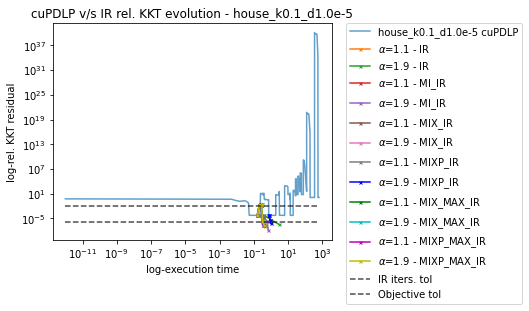

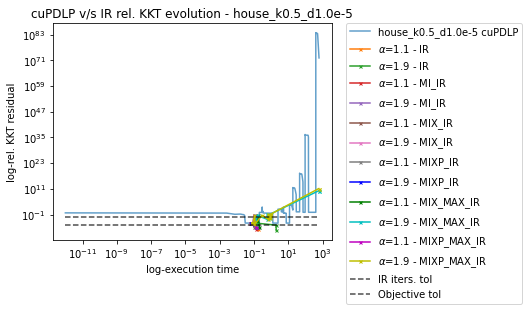

In [5]:



ir_colors = ['C{}'.format(i) for i in range(8)] + ['b', 
    'g', 'c', 'm', 'y', 'k', 'purple', 'brown', 'pink', 'olive', 'lime', 'teal', 'navy', 'fuchsia', 'crimson', 'cadetblue', 'peru']

# Plot each instance
plot_IR_instances(
    instance_list=house_instances,
    output_path=house_instances_output_path,
    ir_iterations_tolerance=ir_tol,
    objective_tolerance=obj_tol,
    x_time_val_source="IR_PDLP", # (PDLP or IR_PDLP)
    ir_scaling_colors=ir_colors,
    scaling_types=scaling_types,
    scaling_dict=scaling_dict,
    alpha_indep_types=alpha_indep_types,
    scaling_alphas=[1.1, 1.9],
    limit_ir_iters=1000,
    show_pdlp_iters=True,
    plot_attributes={
            "figsize":(5,4),
            "markersize":3,
            "title":"cuPDLP v/s IR rel. KKT evolution",
            "y_label":"rel. KKT residual",
            "x_label":"execution time",
            "legend_position":(1.05, 1.0),
            "y_log_scale":True,
            "x_log_scale":True,
            "y_log_values_correction":1e-12,
            "x_log_values_correction":1e-12,
            "x_lim":None, #[1e-2, 1e1], #[-0.5, 1],
            "y_lim":None, #[1e-8, 1e1],# [1e-9, 1e0],
        }
)


In [5]:
# import matplotlib.pyplot as plt
# # json_file = "./output/PDHG_test4/MIPLIB_test/ns1828997/ns1828997_IR_NO_a0_summary.json"
# source = "PDHG_test2"
# # json_dict = open_json_file("ns1828997_IR_NO_a0_summary.json", f"./output/{source}/MIPLIB_test/tiny_instances/ns1828997")
# # json_dict = open_json_file("ns1828997_IR_a1.9_summary.json", f"./output/{source}/MIPLIB_test/tiny_instances/ns1828997")
# instance_name = "house_k0.5_d0.001"
# scaling_type = "IR_NO_a0"
# json_dict = open_json_file(f"{instance_name}_{scaling_type}_summary.json", f"./output/{source}/IR/{instance_name}")
# max_k = 15

# Delta_P = json_dict["Delta_P"][:max_k]
# Delta_D = json_dict["Delta_D"][:max_k]
# primal_objective = json_dict["primal_objective"][:max_k]
# dual_objective = json_dict["dual_objective"][:max_k]
# primal_res = json_dict["l_inf_primal_residual"][:max_k]
# dual_res = json_dict["l_inf_dual_residual"][:max_k]
# opt_gap = json_dict["optimality_gap"][:max_k]
# rel_primal_res = json_dict["relative_l_inf_primal_residual"][:max_k]
# rel_dual_res = json_dict["relative_l_inf_dual_residual"][:max_k]
# rel_opt_gap = json_dict["relative_optimality_gap"][:max_k]

# iters = [k+1 for k in range(len(Delta_P))][:max_k]


# # Create the figure and subplots
# fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(7, 12))  # 1 row, 2 columns



# # KKT
# # ax1.plot(x1, y1, marker='o')
# # ax1.set_title("Plot 1")
# # ax1.set_xlabel("X-axis 1")
# # ax1.set_ylabel("Y-axis 1")

# # plt.figure(figsize=(8,6))
# ax0.plot(iters, rel_primal_res, '-x', label="rel_primal_res")
# ax0.plot(iters, rel_dual_res, '-x', label="rel_dual_res")
# ax0.plot(iters, rel_opt_gap, '-x', label="rel_opt_gap")
# ax0.set_yscale("log")
# ax0.legend()

# # plt.figure(figsize=(8,6))
# ax1.plot(iters, primal_res, '-x', label="primal_res")
# ax1.plot(iters, dual_res, '-x', label="dual_res")
# ax1.plot(iters, opt_gap, '-x', label="opt_gap")
# ax1.set_yscale("log")
# ax1.legend()
# # ax1.plot()
# # plt.ylabel("Values")


# # Deltas

# # ax2.figure(figsize=(8,6))
# # iters = [k for k in range(len(Delta_P))][:max_k]
# ax2.plot(iters, Delta_P, '-x', label="Delta_P")
# ax2.plot(iters, Delta_D, '-x', label="Delta_D")
# ax2.set_yscale("log")
# ax2.legend()
# # ax2.plot()

# # fig.suptitle("Values evolution through iterations")
# plt.xlabel("Iteration")
# plt.show()


# # Topics:
# # 1. Smth is off with the stopping criterion. I have L_inf and tol_IR on everything, but still rel_res and res and far beyond that on some iterations (0,1,etc.)
# # 2. De-scaling in terms of delta does not appear to help the convergence (see v2 vs v4)
# # 3. 

### MIPLIB Instances (without scalar no-alpha and pure_max)

Summary of ex. time of 1 instances of MIPLIB:
Summary of rel. KKT of 1 instances of MIPLIB:


,# Success,SGM10_time,SGM0.0001_kkt
Method,,,
cuPDLP,0,3649.111,9.526843e-03
IR a=1.1,0,3601.573,4.095858e+03
IR a=1.9,0,3601.466,6.491710e+03
IR_NO a-indep.,0,3601.171,6.053531e+03
MI_IR a=1.1,0,3600.957,8.145023e+04
MI_IR a=1.9,0,3600.922,1.566517e+01
D3D2Sw_IR a=1.1,0,3601.946,5.997665e+04
D3D2Sw_IR a=1.9,0,3602.428,9.677642e+01
MIX_IR a=1.1,0,3600.897,2.247611e+12


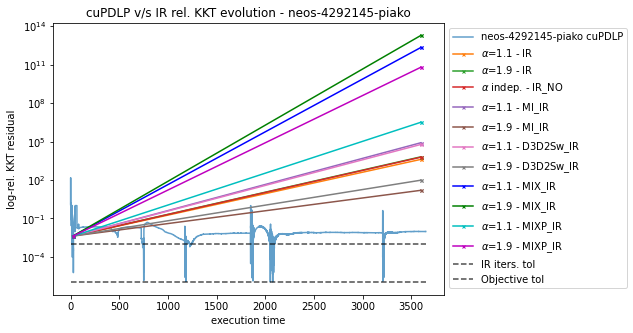

In [8]:
scaling_types = [
    "scalar", 
    "scalar_no_alpha",  # ONLY ON 10 MIN
    # # "D3_eq_D2inv",      # MIPLIB WITHOUT THIS ONE
    # # "D3_eq_D2_and_swap",# MIPLIB WITHOUT THIS ONE
    # # "D3_dual_violation",# MIPLIB WITHOUT THIS ONE
    "D3_eq_D2_eq_I", 
    # "D3_dual_violation_swap", 
    "D3_D2_iterative_swap", 
    "D3_D2_mix", 
    "D3_D2_mix_pure", 
    # "D123_pure",
    # # "D123_pure_max", # ONLY ON 10 MIN
    ]

# # # random sample
# # # np.random.seed(42)
# # # # miplib_instances = np.random.choice(miplib_instances, size=10, replace=False)
# miplib_instances = ["ns1456591", "app1-2", "graph20-80-1rand", "blp-ic98", "piperout-d20", "ns1828997", "neos-4292145-piako", "neos-960392", "d20200", "mushroom-best", 
#                     "bppc6-02", "neos-1354092", "neos-933638", "neos-4300652-rahue", "n2seq36q", "bppc6-06", "neos-933966", "ns1430538"] 
# # # # Falta harto: "neos-5195221-niemur", "neos-5193246-nerang", "germanrr", "ger50-17-trans-dfn-3t", "ger50-17-trans-pop-3t", "neos-5196530-nuhaka", "neos-5266653-tugela", "stockholm"] # faltan algunos

# New v7 instances: 
miplib_instances = ["neos-4292145-piako"] #,  "ns1430538"]

# Output folder
instance_size = "tiny_instances"
source = "PDHG_test8"
miplib_output_path = f"output/{source}/MIPLIB_test/{instance_size}" 

# miplib_instances = get_MIPLIB_instances_list(
#     instances_path=f"output/{source}/MIPLIB_test",
#     instances_size="tiny_instances"
# )
# # miplib_instances.remove("ger50-17-trans-pop-3t") # 10 min
# miplib_instances.remove("neos-4292145-piako") # 30 min


ct = get_intance_comparisson_table(
        instance_list=miplib_instances,    # Instance names only
        output_path=miplib_output_path,    # Path where instance folders are available
        table_value_type="time",        # time, kkt
        time_val_source="IR_PDLP",  # source of the time of original problem (PDLP or IR_PDLP)
        scaling_types=scaling_types,     # List of the scaling types applied to the instances
        scaling_dict=scaling_dict,      # Dictionary of codes of scaling (for visualization purposes)
        alpha_indep_types=alpha_indep_types, # List of the methods that are indep of alpha
        scaling_alphas=[1.1, 1.9],    # Alphas used on every scaling type
    )

# display(ct)

ct_s = comparisson_table_summary(
        comparisson_table=ct,
        criterion_type="time",
        time_limit=600,
        sgm_k_shift=10,
        norm_column="cuPDLP"
)

print(f"Summary of ex. time of {ct.shape[0]} instances of MIPLIB:")
# display(ct_s)

ct_kkt= ct = get_intance_comparisson_table(
        instance_list=miplib_instances,    # Instance names only
        output_path=miplib_output_path,    # Path where instance folders are available
        table_value_type="kkt",        # time, kkt
        time_val_source="IR_PDLP",  # source of the time of original problem (PDLP or IR_PDLP)
        scaling_types=scaling_types,     # List of the scaling types applied to the instances
        scaling_dict=scaling_dict,      # Dictionary of codes of scaling (for visualization purposes)
        alpha_indep_types=alpha_indep_types, # List of the methods that are indep of alpha
        scaling_alphas=[1.1, 1.9],    # Alphas used on every scaling type
    )

# display(ct_kkt)

ct_s_kkt = comparisson_table_summary(
        comparisson_table=ct_kkt,
        criterion_type="kkt",
        objective_tol=1e-6,
        sgm_k_shift=1e-4,
        norm_column="cuPDLP"
)

print(f"Summary of rel. KKT of {ct.shape[0]} instances of MIPLIB:")
# display(ct_s_kkt)


final_table = ct_s.drop(columns=["Mean improve. rate"]).round(3).copy()
col_name = f"{final_table.columns[-1]}"
new_col_name = f"{final_table.columns[-1]}_time"
final_table.rename(columns={col_name:new_col_name}, inplace=True)# 
final_table[ct_s_kkt.columns[-2] + "_kkt"] = 0
final_table.loc[:,ct_s_kkt.columns[-2] + "_kkt"] = ct_s_kkt[ct_s_kkt.columns[-2]].values


display(final_table)

# Plot each instance
plot_IR_instances(
    instance_list=miplib_instances,
    output_path=miplib_output_path, # New instances
    ir_iterations_tolerance=1e-3,
    objective_tolerance=1e-6,
    x_time_val_source="IR_PDLP", # (PDLP or IR_PDLP)
    ir_scaling_colors=ir_colors,
    scaling_types=scaling_types,
    scaling_dict=scaling_dict,
    alpha_indep_types=alpha_indep_types,
    scaling_alphas=[1.1, 1.9],
    limit_ir_iters=1000,
    show_pdlp_iters=True,
    plot_attributes={
            "figsize":(7,5),
            "markersize":3,
            "title":"cuPDLP v/s IR rel. KKT evolution",
            "y_label":"rel. KKT residual",
            "x_label":"execution time",
            "legend_position":(1.0, 1.0), 
            "y_log_scale":True,
            "x_log_scale":False,
            "y_log_values_correction":1e-12,
            "x_log_values_correction":1e-12,
            "x_lim":None,#[-5,122.5],
            "y_lim":None,
        }
)


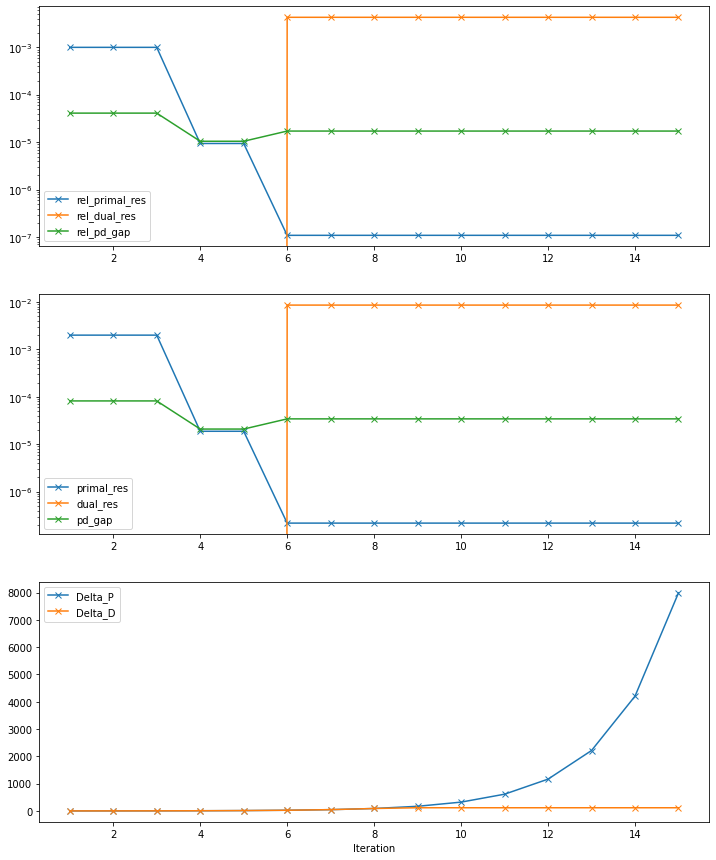

In [ ]:
import matplotlib.pyplot as plt
# json_file = "./output/PDHG_test4/MIPLIB_test/ns1828997/ns1828997_IR_NO_a0_summary.json"
source = "PDHG_test1"
# json_dict = open_json_file("ns1828997_IR_NO_a0_summary.json", f"./output/{source}/MIPLIB_test/tiny_instances/ns1828997")
# json_dict = open_json_file("ns1828997_IR_a1.9_summary.json", f"./output/{source}/MIPLIB_test/tiny_instances/ns1828997")
instance_name = "house_k0.5_d0.001"
scaling_type = 
json_dict = open_json_file(f"{instance_name}_IR_a1.9_summary.json", f"./output/{source}/IR/{instance_name}")
max_k = 15

Delta_P = json_dict["Delta_P"][:max_k]
Delta_D = json_dict["Delta_D"][:max_k]
primal_objective = json_dict["primal_objective"][:max_k]
dual_objective = json_dict["dual_objective"][:max_k]
primal_res = json_dict["l_inf_primal_residual"][:max_k]
dual_res = json_dict["l_inf_dual_residual"][:max_k]
pd_gap = json_dict["optimality_gap"][:max_k]
rel_primal_res = json_dict["relative_l_inf_primal_residual"][:max_k]
rel_dual_res = json_dict["relative_l_inf_dual_residual"][:max_k]
rel_pd_gap = json_dict["relative_optimality_gap"][:max_k]

iters = [k+1 for k in range(len(Delta_P))][:max_k]


# Create the figure and subplots
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(12, 15))  # 1 row, 2 columns



# KKT
# ax1.plot(x1, y1, marker='o')
# ax1.set_title("Plot 1")
# ax1.set_xlabel("X-axis 1")
# ax1.set_ylabel("Y-axis 1")

# plt.figure(figsize=(8,6))
ax0.plot(iters, rel_primal_res, '-x', label="rel_primal_res")
ax0.plot(iters, rel_dual_res, '-x', label="rel_dual_res")
ax0.plot(iters, rel_pd_gap, '-x', label="rel_pd_gap")
ax0.set_yscale("log")
ax0.legend()

# plt.figure(figsize=(8,6))
ax1.plot(iters, primal_res, '-x', label="primal_res")
ax1.plot(iters, dual_res, '-x', label="dual_res")
ax1.plot(iters, pd_gap, '-x', label="pd_gap")
ax1.set_yscale("log")
ax1.legend()
# ax1.plot()

# Deltas
# ax2.figure(figsize=(8,6))
# iters = [k for k in range(len(Delta_P))][:max_k]
ax2.plot(iters, Delta_P, '-x', label="Delta_P")
ax2.plot(iters, Delta_D, '-x', label="Delta_D")
# ax2.set_yscale("log")
ax2.legend()
# ax2.plot()

plt.xlabel("Iteration")
plt.show()


# Topics:
# 1. Smth is off with the stopping criterion. I have L_inf and tol_IR on everything, but still rel_res and res and far beyond that on some iterations (0,1,etc.)
# 2. De-scaling in terms of delta does not appear to help the convergence (see v2 vs v4)
# 3. 

In [68]:
1.9**6

47.04588099999999

In [17]:

scaling_types = [
    "scalar", 
    "scalar_no_alpha",  # ONLY ON 10 MIN
    # # "D3_eq_D2inv",      # MIPLIB WITHOUT THIS ONE
    # # "D3_eq_D2_and_swap",# MIPLIB WITHOUT THIS ONE
    # # "D3_dual_violation",# MIPLIB WITHOUT THIS ONE
    # "D3_eq_D2_eq_I", 
    # "D3_dual_violation_swap", 
    # "D3_D2_iterative_swap", 
    # "D3_D2_mix", 
    # "D3_D2_mix_pure", 
    # "D123_pure",
    # "D123_pure_max", # ONLY ON 10 MIN
    ]

# # # random sample
# # # np.random.seed(42)
# # # # miplib_instances = np.random.choice(miplib_instances, size=10, replace=False)
# miplib_instances = ["ns1456591", "app1-2", "graph20-80-1rand", "blp-ic98", "piperout-d20", "ns1828997", "neos-4292145-piako", "neos-960392", "d20200", "mushroom-best", 
#                     "bppc6-02", "neos-1354092", "neos-933638", "neos-4300652-rahue", "n2seq36q", "bppc6-06", "neos-933966", "ns1430538"] 
# # # Falta harto: "neos-5195221-niemur", "neos-5193246-nerang", "germanrr", "ger50-17-trans-dfn-3t", "ger50-17-trans-pop-3t", "neos-5196530-nuhaka", "neos-5266653-tugela", "stockholm"] # faltan algunos

# Output folder
instance_size = "tiny_instances"
miplib_output_path = f"output/PDHG10/MIPLIB_test/{instance_size}" 

miplib_instances = get_MIPLIB_instances_list(
    instances_path="output/PDHG10/MIPLIB_test",
    instances_size="tiny_instances"
)

miplib_instances.remove("neos-1122047") # 30 min


ct = get_intance_comparisson_table(
        instance_list=miplib_instances,    # Instance names only
        output_path=miplib_output_path,    # Path where instance folders are available
        table_value_type="time",        # time, kkt
        time_val_source="IR_PDLP",  # source of the time of original problem (PDLP or IR_PDLP)
        scaling_types=scaling_types,     # List of the scaling types applied to the instances
        scaling_dict=scaling_dict,      # Dictionary of codes of scaling (for visualization purposes)
        alpha_indep_types=alpha_indep_types, # List of the methods that are indep of alpha
        scaling_alphas=[1.1, 1.5, 1.9],    # Alphas used on every scaling type
    )

# display(ct)

ct_s = comparisson_table_summary(
        comparisson_table=ct,
        criterion_type="time",
        time_limit=600,
        sgm_k_shift=10,
        norm_column="cuPDLP"
)

print(f"Summary of ex. time of {ct.shape[0]} instances of MIPLIB:")
# display(ct_s)

ct_kkt= ct = get_intance_comparisson_table(
        instance_list=miplib_instances,    # Instance names only
        output_path=miplib_output_path,    # Path where instance folders are available
        table_value_type="kkt",        # time, kkt
        time_val_source="IR_PDLP",  # source of the time of original problem (PDLP or IR_PDLP)
        scaling_types=scaling_types,     # List of the scaling types applied to the instances
        scaling_dict=scaling_dict,      # Dictionary of codes of scaling (for visualization purposes)
        alpha_indep_types=alpha_indep_types, # List of the methods that are indep of alpha
        scaling_alphas=[1.1, 1.5, 1.9],    # Alphas used on every scaling type
    )

# display(ct_kkt)

ct_s_kkt = comparisson_table_summary(
        comparisson_table=ct_kkt,
        criterion_type="kkt",
        objective_tol=1e-6,
        sgm_k_shift=1e-4,
        norm_column="cuPDLP"
)

print(f"Summary of rel. KKT of {ct.shape[0]} instances of MIPLIB:")
# display(ct_s_kkt)

# # Plot each instance
# plot_IR_instances(
#     instance_list=miplib_instances,
#     output_path=miplib_output_path, # New instances
#     ir_iterations_tolerance=1e-3,
#     objective_tolerance=1e-6,
#     x_time_val_source="IR_PDLP", # (PDLP or IR_PDLP)
#     ir_scaling_colors=ir_colors,
#     scaling_types=scaling_types,
#     scaling_dict=scaling_dict,
#     alpha_indep_types=alpha_indep_types,
#     scaling_alphas=[1.1, 1.5, 1.9],
#    limit_ir_iters=1000,
#     plot_attributes={
#             "figsize":(6,4),
#             "markersize":3,
#             "title":"cuPDLP v/s IR rel. KKT evolution",
#             "y_label":"rel. KKT residual",
#             "x_label":"execution time",
#             "legend_position":(1.0, 1.0),
#             "y_log_scale":True,
#             "x_log_scale":False,
#             "y_log_values_correction":1e-12,
#             "x_log_values_correction":1e-12
#         }
# )

final_table = ct_s.drop(columns=["Mean improve. rate"]).round(3).copy()
col_name = f"{final_table.columns[-1]}"
new_col_name = f"{final_table.columns[-1]}_time"
final_table.rename(columns={col_name:new_col_name}, inplace=True)# 
final_table[ct_s_kkt.columns[-2] + "_kkt"] = 0
final_table.loc[:,ct_s_kkt.columns[-2] + "_kkt"] = ct_s_kkt[ct_s_kkt.columns[-2]].values
final_table

[Errno 2] No such file or directory: 'output/PDHG10/MIPLIB_test/tiny_instances/dws008-03/dws008-03_PDLP_a0_summary.json'
[Errno 2] No such file or directory: 'output/PDHG10/MIPLIB_test/tiny_instances/ger50-17-trans-dfn-3t/ger50-17-trans-dfn-3t_PDLP_a0_summary.json'
[Errno 2] No such file or directory: 'output/PDHG10/MIPLIB_test/tiny_instances/ger50-17-trans-pop-3t/ger50-17-trans-pop-3t_PDLP_a0_summary.json'
[Errno 2] No such file or directory: 'output/PDHG10/MIPLIB_test/tiny_instances/germanrr/germanrr_PDLP_a0_summary.json'
[Errno 2] No such file or directory: 'output/PDHG10/MIPLIB_test/tiny_instances/neos-5196530-nuhaka/neos-5196530-nuhaka_PDLP_a0_summary.json'
[Errno 2] No such file or directory: 'output/PDHG10/MIPLIB_test/tiny_instances/neos-5266653-tugela/neos-5266653-tugela_PDLP_a0_summary.json'
[Errno 2] No such file or directory: 'output/PDHG10/MIPLIB_test/tiny_instances/neos-953928/neos-953928_PDLP_a0_summary.json'
[Errno 2] No such file or directory: 'output/PDHG10/MIPLIB_test

ZeroDivisionError: division by zero

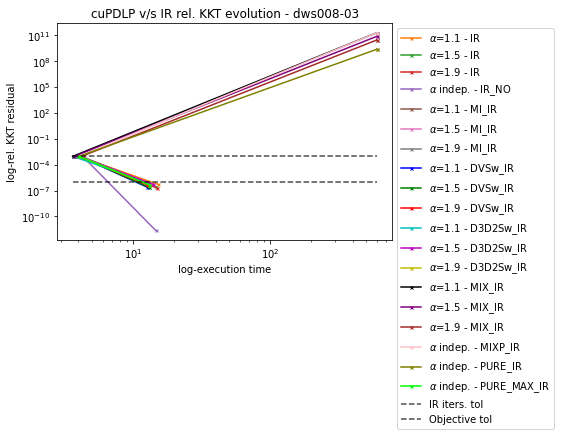

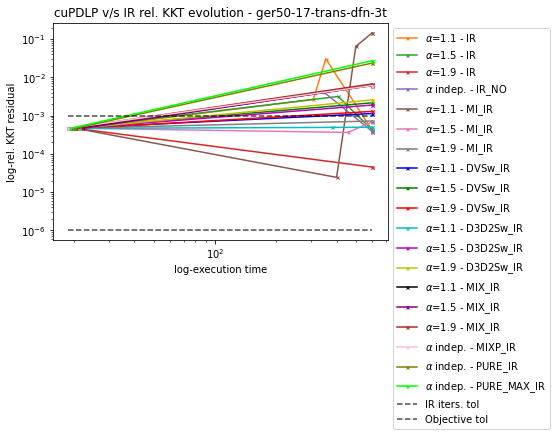

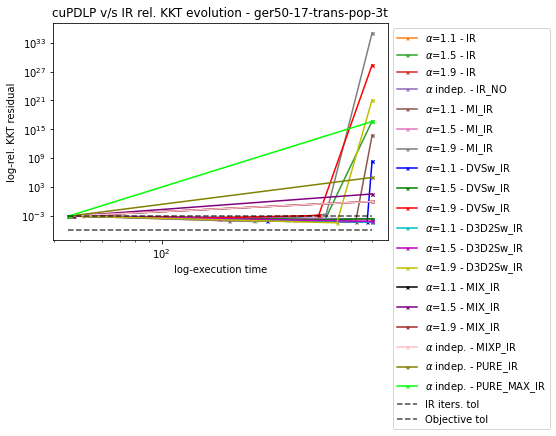

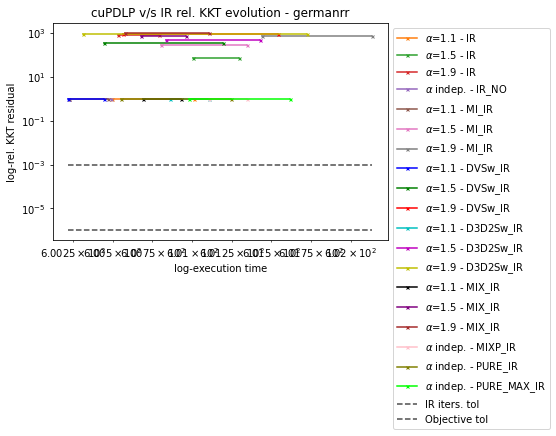

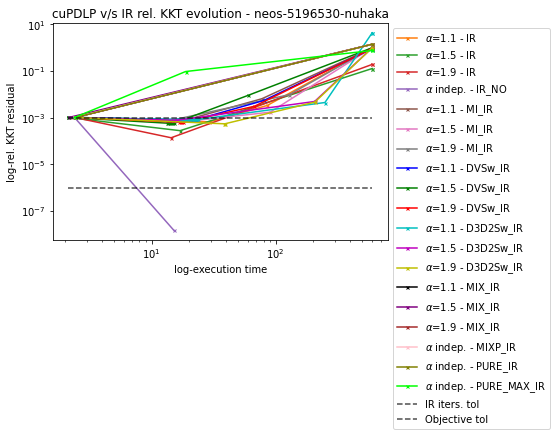

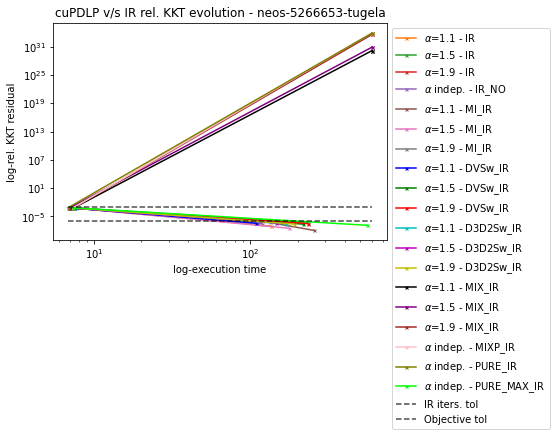

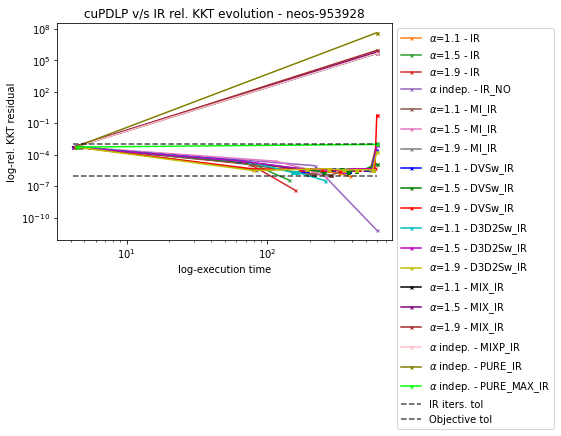

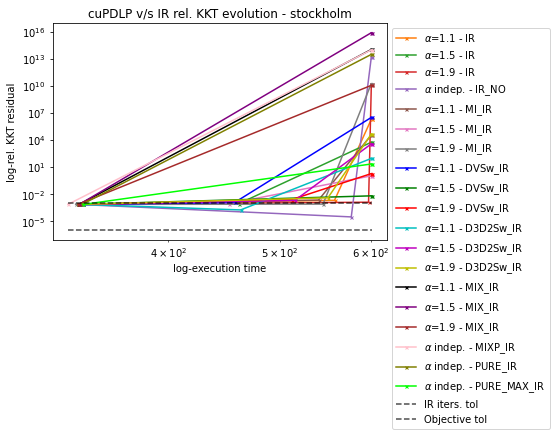

In [75]:
# Plot each instance
plot_IR_instances(
    instance_list=miplib_instances,
    output_path=miplib_output_path, # New instances
    ir_iterations_tolerance=1e-3,
    objective_tolerance=1e-6,
    x_time_val_source="IR_PDLP", # (PDLP or IR_PDLP)
    ir_scaling_colors=ir_colors,
    scaling_types=scaling_types,
    scaling_dict=scaling_dict,
    alpha_indep_types=alpha_indep_types,
    scaling_alphas=[1.1, 1.5, 1.9],
    limit_ir_iters=1000,
    show_pdlp_iters=False,
    plot_attributes={
            "figsize":(6,4),
            "markersize":3,
            "title":"cuPDLP v/s IR rel. KKT evolution",
            "y_label":"rel. KKT residual",
            "x_label":"execution time",
            "legend_position":(1.0, 1.0), 
            "y_log_scale":True,
            "x_log_scale":True,
            "y_log_values_correction":1e-12,
            "x_log_values_correction":1e-12
        }
)


Notes: 
1. cuPDLP has is not consistent in the # of success, because it is stopping before achieving linf_norm <= tol. Hence, it is a success in terms of time (it finishes before the time limit), but it is not a success in terms of the linf_norm. [I need to re-run the experiments with a different stopping criterion (l_inf norm <= tol) to have a fair comparison]





---

1. Convergence oh the house problem in $\Re^2$, with different paramters $\delta$ and $\kappa$ (based on the paper of geometry PDHG for LP).

Testing functions


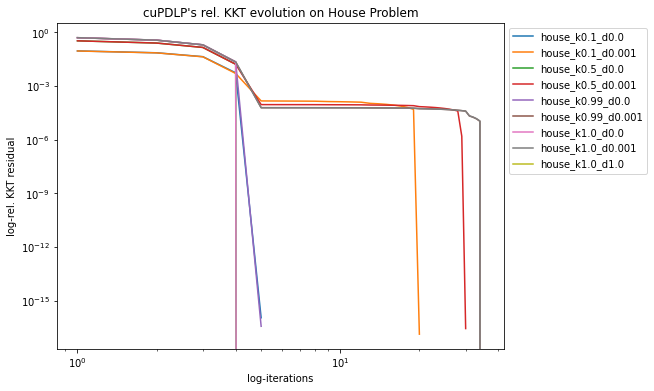

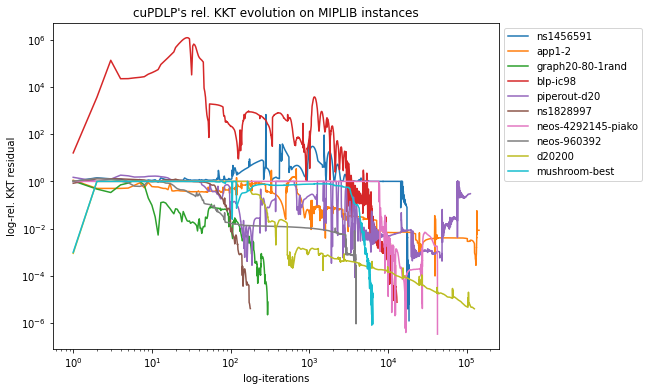

END


In [9]:
print("Testing functions")
house_instances = get_house_instances_list(
    kappas=[0.1, 0.5, 0.99, 1.0],
    deltas=[0.0, 1e-3, 1.0],
    kappa_bound=True
)
plot_PDLP_instances(
    instance_list=house_instances,
    output_path="output/PDHG/IR",
    plot_attributes={
            "figsize":(8,6),
            "title":"cuPDLP's rel. KKT evolution on House Problem",
            "y_label":"rel. KKT residual",
            "x_label":"iterations",
            "legend_position":(1.0, 1.0),
            "y_log_scale":True,
            "x_log_scale":True,
        }
)

# # MIPLIB instances
# miplib_instances = get_MIPLIB_instances_list(
#     instances_path="output/PDHG/MIPLIB_test",
#     instances_size="tiny_instances"
# )

# # random sampel 
# np.random.seed(42)
# miplib_instances = np.random.choice(miplib_instances, size=5)
miplib_instances = ["ns1456591", "app1-2", "graph20-80-1rand", "blp-ic98", "piperout-d20", "ns1828997", "neos-4292145-piako", "neos-960392", "d20200", "mushroom-best"] 
plot_PDLP_instances(
    instance_list=miplib_instances,
    output_path="output/PDHG/MIPLIB_test/tiny_instances",
    plot_attributes={
            "figsize":(8,6),
            "title":"cuPDLP's rel. KKT evolution on MIPLIB instances",
            "y_label":"rel. KKT residual",
            "x_label":"iterations",
            "legend_position":(1.0, 1.0),
            "y_log_scale":True,
            "x_log_scale":True,
        }
)
print("END")




Testing functions


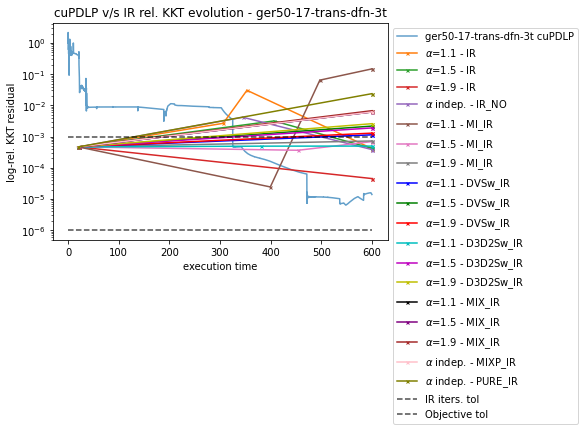

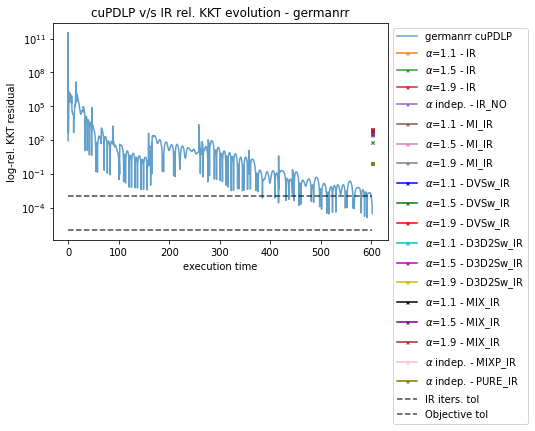

In [84]:


print("Testing functions")
ir_colors = ['C{}'.format(i) for i in range(8)] + ['b', 
    'g', 'r', 'c', 'm', 'y', 'k', 'purple', 'brown', 'pink', 'olive', 'lime', 'teal', 'navy', 'fuchsia', 'crimson', 'cadetblue', 'peru']
# scaling_types = [
#     "scalar", 
#     # "scalar_no_alpha",  # MIPLIB WITHOUT THIS ONE
#     # "D3_eq_D2inv",      # MIPLIB WITHOUT THIS ONE
#     # "D3_eq_D2_and_swap",# MIPLIB WITHOUT THIS ONE
#     # "D3_dual_violation",# MIPLIB WITHOUT THIS ONE
#     # "D3_eq_D2_eq_I", 
#     # "D3_dual_violation_swap", 
#     # "D3_D2_iterative_swap", 
#     "D3_D2_mix", 
#     "D3_D2_mix_pure", 
#     "D123_pure"
#     ]

# scaling_dict = {
#     "scalar":"IR",              # Original scalar IR
#     "scalar_no_alpha":"IR_NO",  # Scalar scaling without alpha, and bounded 
#     "D3_eq_D2inv": "MD2_IR",    # D2 is f(l-x), and D3 = 1 ./D2
#     "D3_eq_D2_eq_I": "MI_IR",   # D3 = D2 = I (only D1 scaling)
#     "D3_dual_violation_swap":"DVSw_IR", # D3 is f(c-A'y), and D2 = 1 ./D3
#     "D3_D2_iterative_swap":"D3D2Sw_IR", # even k: D2 is f(l-x), and D3 = 1 ./D2 // odd k: # D3 is f(c-A'y), and D2 = 1 ./D3
#     "D3_D2_mix": "MIX_IR",       # D2 = min(1/d2 , d3, alpha*D2), and D3 = 1 ./D2 (Does this make sense??)
#     "D3_D2_mix_pure": "MIXP_IR", # D2 = min(1/d2 , d3), and D3 = 1 ./D2 (Does this make sense??)
#     "D123_pure":"PURE_IR"        # D2 = min(1/d2 , d3), D3 = 1 ./D2, and D1 = 1/d1
# }

# alpha_indep_types=[
#     "scalar_no_alpha",
#     "D3_D2_mix_pure",
#     "D123_pure"
# ]


# # House instances
# house_instances = get_house_instances_list(
#     kappas=[0.1, 0.5, 0.99, 1.0],
#     deltas=[0.0, 1e-3, 1.0],
#     kappa_bound=True
# )

# plot_IR_instances(
#     instance_list=house_instances,
#     output_path="output/PDHG/IR",
#     ir_iterations_tolerance=1e-3,
#     objective_tolerance=1e-6,
#     x_time_val_source="IR_PDLP", # (PDLP or IR_PDLP)
#     ir_scaling_colors=ir_colors,
#     scaling_types=scaling_types,
#     scaling_dict=scaling_dict,
#     alpha_indep_types=alpha_indep_types,
#     scaling_alphas=[1.1, 1.5, 1.9],
#     limit_ir_iters=1,
#     plot_attributes={
#             "figsize":(6,4),
#             "markersize":3,
#             "title":"cuPDLP v/s IR rel. KKT evolution",
#             "y_label":"rel. KKT residual",
#             "x_label":"execution time",
#             "legend_position":(1.0, 1.0),
#             "y_log_scale":True,
#             "x_log_scale":True,
#             "y_log_values_correction":1e-12,
#             "x_log_values_correction":1e-12
#         }
# )


# scaling_types = [
#     "scalar", 
#     "D3_eq_D2_eq_I",   
#     "D3_dual_violation_swap", 
#     "D3_D2_iterative_swap", 
#     "D3_D2_mix", 
#     "D3_D2_mix_pure", 
#     "D123_pure"
#     ]


# # MIPLIB instances
# miplib_instances = get_MIPLIB_instances_list(
#     instances_path="output/PDHG/MIPLIB_test",
#     instances_size="tiny_instances"
# )

# # # random sample
# # # np.random.seed(42)
# # # # miplib_instances = np.random.choice(miplib_instances, size=10, replace=False)
# miplib_instances = ["ns1456591", "app1-2", "graph20-80-1rand", "blp-ic98", "piperout-d20", "ns1828997", "neos-4292145-piako", "neos-960392", "d20200", "mushroom-best", 
#                     "bppc6-02", "neos-1354092", "neos-933638", "neos-4300652-rahue", "n2seq36q", "bppc6-06", "neos-933966", "ns1430538"] 
# # # Falta harto: "neos-5195221-niemur", "neos-5193246-nerang", "germanrr", "ger50-17-trans-dfn-3t", "ger50-17-trans-pop-3t", "neos-5196530-nuhaka", "neos-5266653-tugela", "stockholm"] # faltan algunos

# # 30 min instances
# # miplib_instances = ["neos-5195221-niemur"]
plot_IR_instances(
    instance_list=miplib_instances,
    output_path=miplib_output_path, # New instances
    ir_iterations_tolerance=1e-3,
    objective_tolerance=1e-6,
    x_time_val_source="IR_PDLP", # (PDLP or IR_PDLP)
    ir_scaling_colors=ir_colors,
    scaling_types=scaling_types,
    scaling_dict=scaling_dict,
    alpha_indep_types=alpha_indep_types,
    scaling_alphas=[1.1, 1.5, 1.9],
   limit_ir_iters=10,
    plot_attributes={
            "figsize":(6,4),
            "markersize":3,
            "title":"cuPDLP v/s IR rel. KKT evolution",
            "y_label":"rel. KKT residual",
            "x_label":"execution time",
            "legend_position":(1.0, 1.0),
            "y_log_scale":True,
            "x_log_scale":False,
            "y_log_values_correction":1e-12,
            "x_log_values_correction":1e-12
        }
)

Comparisson with the different IR, changing $\alpha$ parameter.

Note: $\alpha=1024$ means $\alpha$ is set to the condition number of the problem matrix normalized, i.e. $\kappa(P)=\frac{\sigma_{max}(P)}{\sigma_{min^+}(P)}$, with $P=[A/ \|A\|\quad b/ \|b\|; c'/\|c\|\quad 0]$ (give this a 2nd thought).

Why? It appears that the important coefficient is $\alpha$ itself, not $1/\delta$ (see Theorem 3.1). To be precise, we want $\Delta P$ to be as big as possible, and we set $1/\delta$ as a limit for this scaling factor.


Given this, we want $\alpha$ as big as possible, without caussing numerical issues ($\alpha>1$ is just so we are zooming in, it is not a necessary condition for the theory). It seems to finish faster than other $\alpha$ for house-shape, and it does not give numerical problems (also 1 real instance. check it on results).

Testing functions


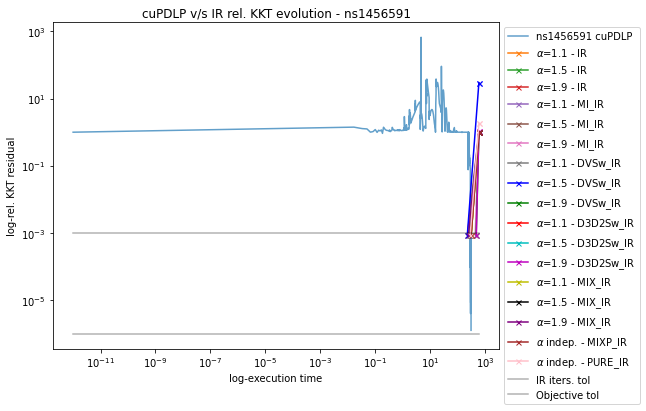

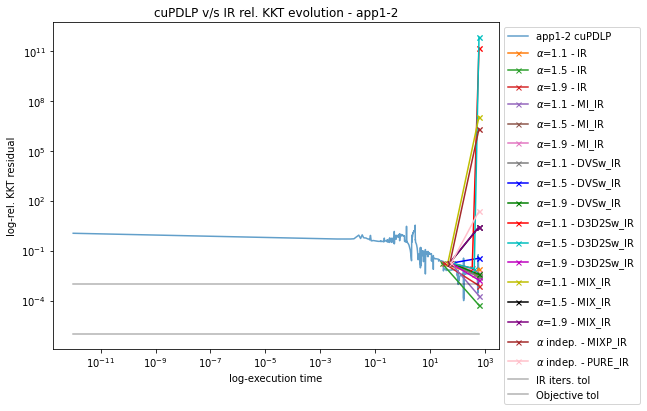

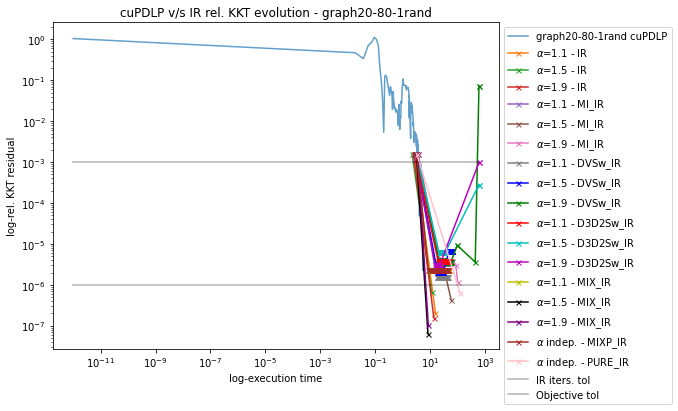

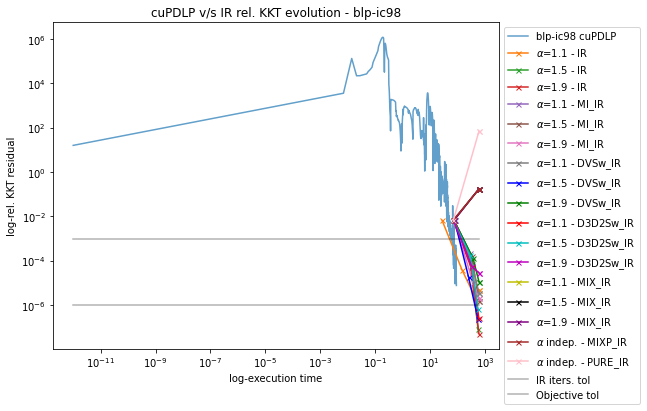

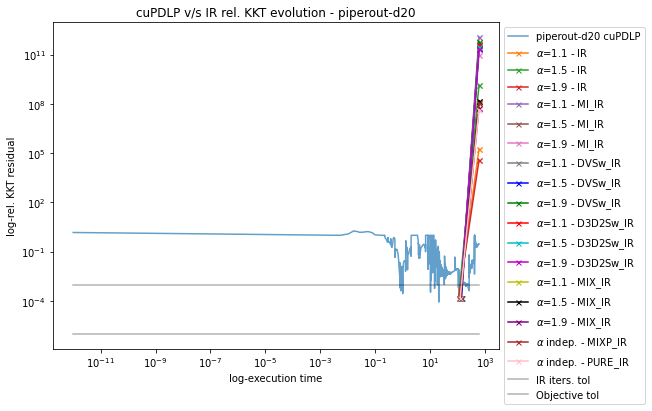

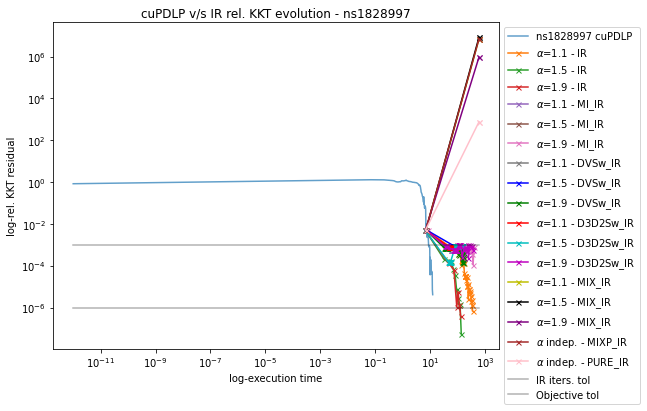

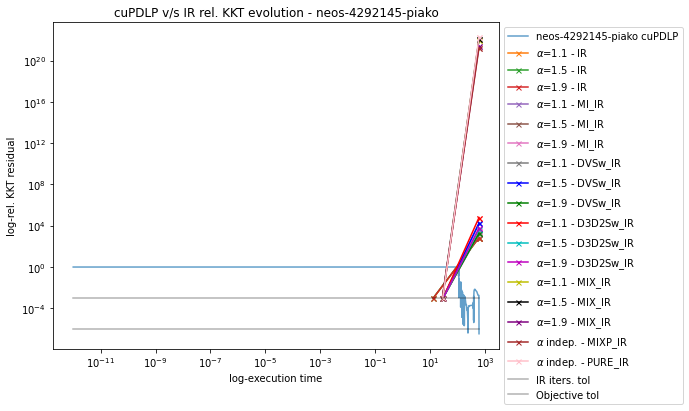

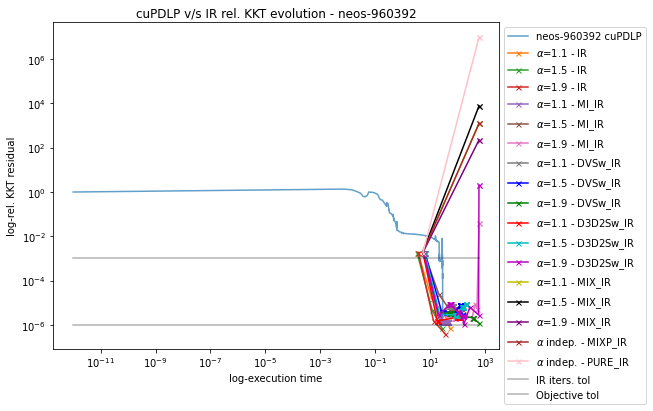

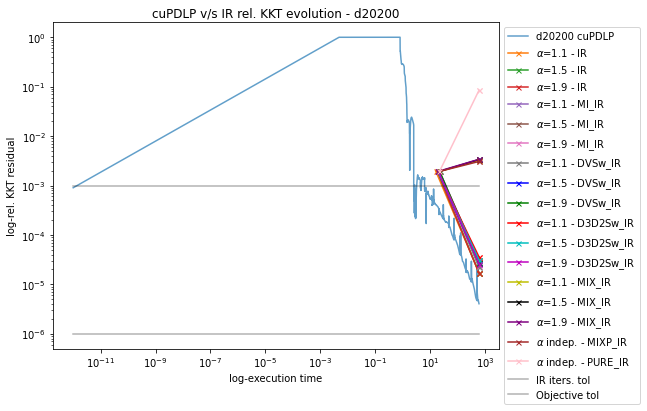

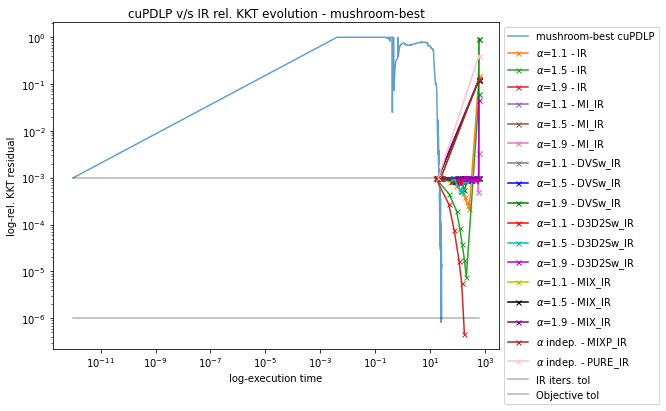

END


In [66]:
import json 
import gzip
import numpy as np
import matplotlib.pyplot as plt

# l2_norm = lambda x: np.sqrt( np.array(x) @ np.array(x) )

    


# MINE
# for kappa in [0.01, 0.1, 0.99]:
#     for delta in [kappa/100, kappa/10, kappa]:

# # MINE 2: Rational kappa, and easy delta (to prove is not that, and it is near-deg)
# for kappa in [0.987654321987654321, 0.987654321, 0.98]:
#     for delta in [0.987, 0.985654321, 0.90987654321987654321]:

# # # Paper (more or less)
# for kappa in [1.0]:




# corr_to_x = 1e-10
# corr_to_y = 1e-10
# for kappa in [0.1, 0.5, 0.99, 1.0]:
#     for delta in [0.0, 1e-3, 1.0]:
# #     # for delta in [1.0]:
#         if delta <= kappa:

#             plt.figure(figsize=(8,6))

#             # Example output to test
#             output_directory = f"output/PDHG/IR/house_k{kappa}_d{delta}"
#             output_file = f"house_k{kappa}_d{delta}_full_log.json.gz"
#             # output_file_2 = f"house_k{kappa}_d{delta}_iter_stats.json.gz"

#             output_directory2 = f"output/PDHG/IR/house_k{kappa}_d{delta}"
#             output_file2 = f"house_k{kappa}_d{delta}_PDLP_summary.json"
#             # output_file_2 = f"house_k{kappa}_d{delta}_iter_stats.json.gz"

#             # Load the output file
#             with open(f"{output_directory2}/{output_file2}", "rt") as f:
#                 output2 = json.load(f)



#             # Load the output file
#             with gzip.open(f"{output_directory}/{output_file}", "rt") as f:
#                 output = json.load(f)
#             # with gzip.open(f"{output_directory}/{output_file_2}", "rt") as f:
#             #     output_2 = json.load(f)
            

#             instance = output["instance_name"]
#             n_iters = output["iteration_count"]
#             # solve_time = output["solve_time_sec"] # Direct time of PDLP 
#             solve_time = output2['total_time'] # Non-direct time (with IR garbage time) 

#             # import numpy as np

#             # print("iters:", n_iters)
#             # print("solve_time:", solve_time)
#             x_values = np.linspace(corr_to_x, solve_time, num=n_iters+1)
#             # print("x:",x_values)

#             kkt_keys = [
#                 "relative_l_inf_primal_residual", # primal feas.
#                 "relative_l_inf_dual_residual", # dual feas. 
#                 "relative_optimality_gap" # optimality gap between primal and dual (comp. slackness implicitly)
#                 ]


#             kkt_values = []
#             force_continue = False
#             for k in range(int(n_iters)+1):
#                 # print(f"iteration {k}")
#                 iter_kkt_values = []
#                 for key in kkt_keys:
#                     # print(f"{key}: {output['iteration_stats'][k]['convergence_information'][0][key]}")
#                     try:
#                         iter_kkt_values.append(output["iteration_stats"][k]['convergence_information'][0][key])
#                     except Exception as e:
#                         print("error in:",kappa,delta,k)
#                         print(e)
#                         print(len(output["iteration_stats"]))
#                         # print(len(output_2))
#                         break
                        


#                 kkt_values.append(linf_norm(iter_kkt_values)+corr_to_y)
#                 # print("iter kkt vals.:", iter_kkt_values)
#                 # print("kkt:", )
                
#                 # output["iteration_stats"][k]
#                 # print(f"{output['iteration_stats'][k]}")



#             # Plot the kkt evolution through the iterations
#             # k_iters = [k+1 for k in range(n_iters+1)]
#             plt.plot(x_values, kkt_values, '-', label=fr"($\kappa$,$\delta$)={(kappa,delta)}", alpha=0.7, c='C0')#markerfacecolor='none')
#             # plt.plot(x_values, kkt_values, 'o', label=fr"($\kappa$,$\delta$)={(kappa,delta)}", alpha=0.7, c='C0')#markerfacecolor='none')


#             # Plot colors
#             colors = ['C{}'.format(i) for i in range(8)] + ['b', 
#                       'g', 'r', 'c', 'm', 'y', 'k', 'purple', 'brown', 'pink', 'olive', 'lime', 'teal', 'navy', 'fuchsia', 'crimson', 'cadetblue', 'peru']
#             color_index = 0

#             # Adding IR plots
#             for alpha in [1.1, 1.5, 1.9]: # , 1024
#                 scaling_dict = {

#                     "scalar":"IR", # Original scalar IR
#                     "scalar_no_alpha":"IR_NO", # Scalar without alpha, and bounded
#                     "D3_eq_D2inv": "MD2_IR",    # D2 is f(l-x), and D3 = 1 ./D2
#                     "D3_eq_D2_eq_I": "MI_IR",   # D3 = D2 = I (only D1 scaling)
#                     "D3_dual_violation_swap":"DVSw_IR", # D3 is f(c-A'y), and D2 = 1 ./D3
#                     "D3_D2_iterative_swap":"D3D2Sw_IR", # even k: D2 is f(l-x), and D3 = 1 ./D2 // odd k: # D3 is f(c-A'y), and D2 = 1 ./D3
#                     "D3_D2_mix": "MIX_IR",       # D2 = min(1/d2 , d3, alpha*D2), and D3 = 1 ./D2 (Does this make sense??)
#                     "D3_D2_mix_pure": "MIXP_IR", # D2 = min(1/d2 , d3), and D3 = 1 ./D2 (Does this make sense??)
#                     "D123_pure":"PURE_IR"        # D2 = min(1/d2 , d3), D3 = 1 ./D2, and D1 = 1/d1
#                     }
#                 for scaling_type in ["scalar", "scalar_no_alpha", "D3_eq_D2_eq_I",   "D3_dual_violation_swap", "D3_D2_iterative_swap", "D3_D2_mix", "D3_D2_mix_pure", "D123_pure"]:
#                     # BAD RESULTS: "D3_eq_D2inv", 
#                     color_index+=1

#                     # Example output to test
#                     output_directory = f"output/PDHG/IR/house_k{kappa}_d{delta}"
#                     output_file = f"house_k{kappa}_d{delta}_{scaling_dict[scaling_type]}_a{alpha}_summary.json"
#                     # output_file_2 = f"house_k{kappa}_d{delta}_iter_stats.json.gz"

#                     # Load the output file
#                     with open(f"{output_directory}/{output_file}", "rt") as f:
#                         output = json.load(f)
#                     # with gzip.open(f"{output_directory}/{output_file_2}", "rt") as f:
#                     #     output_2 = json.load(f)
                    
#                     # print(output)

#                     instance = output["instance"]
#                     # print("instance:", instance)
#                     n_iters = output["last_iteration"]
#                     # print("IR iterations:", n_iters)

#                     kkt_keys = [
#                         "relative_l_inf_primal_residual", # primal feas.
#                         "relative_l_inf_dual_residual", # dual feas. 
#                         "relative_optimality_gap" # optimality gap between primal and dual (comp. slackness implicitly)
#                         ]

#                     start_time_IR = corr_to_x
#                     x_vals = []
#                     y_vals = []
#                     # print('-'*20)
#                     # print(fr"($\kappa$,$\delta$,$\alpha$)={(kappa,delta,alpha)} - {scaling_dict[scaling_type]}")
#                     # print(np.array([
#                     #         output[kkt_keys[0]],
#                     #         output[kkt_keys[1]],
#                     #         output[kkt_keys[2]]
#                     #         ]))
#                     for i in range(n_iters+1):
#                         # print("first kkt key in iter",i,": ",output[kkt_keys[0]][i])

#                         kkt_values = np.array([
#                             output[kkt_keys[0]][i],
#                             output[kkt_keys[1]][i],
#                             output[kkt_keys[2]][i]
#                             ])
#                         # if delta==0.0:
#                         #     print("kkt array",kkt_values)

#                         # print(kkt_values)
#                         kkt_value = linf_norm(kkt_values) + corr_to_y
#                         # print(kkt_value)

#                         start_time_IR+=output['blackbox_time'][i]
#                         # print(start_time_IR)
                    
#                         x_vals.append(start_time_IR)
#                         y_vals.append(kkt_value)

#                         # Only first iter
#                         if i >= 3:
#                             break

#                     # if delta==0.0:
#                     #     print(output)

#                     if len(x_vals) > 0:
#                         # k_iters = [k+1 for k in range(n_iters+1)]
#                         # 'x'
#                         plt.plot(x_vals, y_vals, '-x',label=fr"$\alpha$={alpha} - {scaling_dict[scaling_type]}", color=colors[color_index], markersize=3) # -x
#                         # print(x_vals)
#                         # print(y_vals)




#             plt.legend( bbox_to_anchor=(1, 0.8))
#             plt.title(f"cuPDLP on House-Shaped problem ($\kappa$,$\delta$)={(kappa,delta)}")
#             plt.ylabel("KKT residual")
#             plt.xlabel("Time (secs)")
#             plt.yscale('log')
#             # plt.xscale('log')
#             plt.show()

            


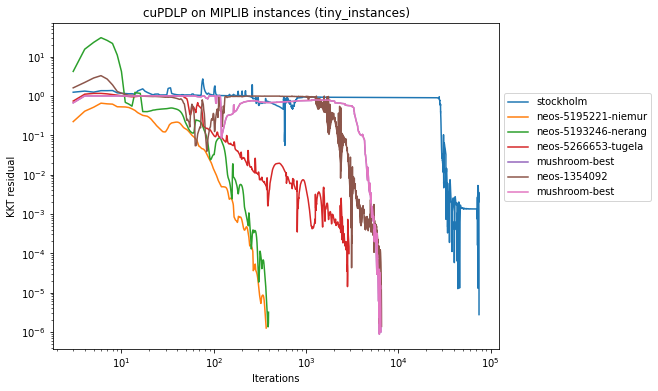

In [39]:
import json 
import gzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os



l2_norm = lambda x: np.sqrt( np.array(x) @ np.array(x) )


plt.figure(figsize=(8,6))


# Example output to test
data_size = "tiny_instances"
output_directory = f"output/PDHG/MIPLIB_test/{data_size}/"
output_folders = os.listdir(output_directory)

instances_sample_size = 20
# np.random.seed(42)
output_folders = np.random.choice(output_folders, instances_sample_size)

for instance_name in output_folders:
    # print("-"*50)
    # print(instance_name)
    output_folder_dir = output_directory + instance_name + "/"
    output_files = os.listdir(output_folder_dir)
    # print(output_files)

    # Check for direct PDLP file
    if f"{instance_name}_summary.json" in output_files and f"{instance_name}_PDLP_summary.json" in output_files:


        # Example output to test
        output_directory_ = f"output/PDHG/MIPLIB_test/{data_size}/{instance_name}"
        output_file = f"{instance_name}_full_log.json.gz"
        # output_file_2 = f"house_k{kappa}_d{delta}_iter_stats.json.gz"


        # Load the output file
        with gzip.open(f"{output_directory_}/{output_file}", "rt") as f:
            output = json.load(f)
        # print(output)
        # with gzip.open(f"{output_directory}/{output_file_2}", "rt") as f:
        #     output_2 = json.load(f)

        # print("output readed")        

        instance = output["instance_name"]
        n_iters = output["iteration_count"]

        kkt_keys = [
            "relative_l_inf_primal_residual", # primal feas.
            "relative_l_inf_dual_residual", # dual feas. 
            "relative_optimality_gap" # optimality gap between primal and dual (comp. slackness implicitly)
            ]


        kkt_values = []
        # force_continue = False
        for k in range(int(n_iters)+1):
            # print(f"iteration {k}")
            iter_kkt_values = []
            for key in kkt_keys:
                # print(f"{key}: {output['iteration_stats'][k]['convergence_information'][0][key]}")
                try:
                    iter_kkt_values.append(output["iteration_stats"][k]['convergence_information'][0][key])
                except Exception as e:
                    # print("error in:",kappa,delta,k)
                    # print(e)
                    # print(len(output["iteration_stats"]))
                    # print(len(output_2))
                    break
                    


            kkt_values.append(linf_norm(iter_kkt_values))
            # print("iter kkt vals.:", iter_kkt_values)
            # print("kkt:", )
            
            # output["iteration_stats"][k]
            # print(f"{output['iteration_stats'][k]}")


        # EXTRA: Apply moving averages to get a better picture
        data = pd.Series(kkt_values)
        # Calculate a 3-period moving average
        moving_average = data.rolling(window=3).mean()
        # print("kkt size", len(kkt_values))
        # print("avg size", len(moving_average))

        # Plot the kkt evolution through the iterations
        k_iters = [k+1 for k in range(n_iters+1)]
        # plt.plot(k_iters, kkt_values, label=fr"{instance_name}") # Normal plot
        plt.plot(k_iters, moving_average, label=fr"{instance_name}") # Moving averages plot
plt.legend( bbox_to_anchor=(1, 0.8))
plt.yscale('log')
plt.xscale('log')
plt.title(f"cuPDLP on MIPLIB instances ({data_size})")
plt.ylabel("KKT residual")
plt.xlabel("Iterations")
plt.show()


In [2]:
import json 
import gzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os



# l2_norm = lambda x: np.sqrt( np.array(x) @ np.array(x) )


plt.figure(figsize=(8,6))


# Example output to test
data_size = "tiny_instances"
output_directory = f"output/PDHG/MIPLIB_test/{data_size}/"
output_folders = os.listdir(output_directory)

instances_sample_size = min(100, len(output_folders))
# np.random.seed(42)
# output_folders = np.random.choice(output_folders, instances_sample_size, replace=False)
output_folders = ["ns1456591", "app1-2", "graph20-80-1rand", "blp-ic98", "piperout-d20", "ns1828997", "neos-4292145-piako", "neos-960392", "d20200", "mushroom-best", "bppc6-02", "neos-1354092", "neos-933638", "neos-4300652-rahue", "n2seq36q", "bppc6-06", "neos-933966", "ns1430538", "neos-5195221-niemur", "neos-5193246-nerang", "germanrr", "ger50-17-trans-dfn-3t", "ger50-17-trans-pop-3t", "neos-5196530-nuhaka", "neos-5266653-tugela", "stockholm", "neos-953928", "dws008-03", "neos-1122047", "eva1aprime6x6opt", "supportcase23", "cmflsp50-24-8-8", "sorrell7", "physiciansched5-3", "bab5", "pb-grow22", "gmut-76-40", "opm2-z8-s0", "neos-913984", "mzzv42z", "neos-498623", "sct5", "ns930473", "iis-hc-cov", "neos-4954274-beardy", "neos-824661", "reblock420", "supportcase37", "chromaticindex512-7", "fhnw-binschedule2", "mzzv11", "neos-5013590-toitoi", "neos-5188808-nattai", "brazil3", "t1722", "dws012-01", "neos-1171448", "leo1", "ci-s4", "neos-826224", "cmflsp40-24-10-7", "unitcal_7", "neos-4359986-taipa", "satellites2-60-fs", "shipsched", "fhnw-schedule-paira200", "blp-ic97", "neos-4805882-barwon", "ns1631475", "neos-3372571-onahau", "neos-1593097", "rmatr200-p5", "neos-827175", "30n20b8", "sct32", "neos-932721", "lr1dr04vc05v17a-t360", "ns1856153", "sct1", "rmatr200-p10", "2club200v15p5scn", "fiball", "supportcase40", "neos-950242", "v150d30-2hopcds", "momentum1", "ex1010-pi", "neos-578379", "neos-738098", "ns1830653"]


corr_to_x = 1e-10
corr_to_y = 1e-10

# Loop all the instance names (which are also folders) of the output
for instance_name in output_folders:
    print("-"*50)
    print(instance_name)

    # New directory, is: the old one / the instance name / 
    output_folder_dir = output_directory + "/" + instance_name
    output_files = os.listdir(output_folder_dir) # List of all files in that directory (summary of diff. models, iter_stats, log, etc)

    # Check for the direct PDLP file and the IR direct PDLP
    if f"{instance_name}_summary.json" in output_files and \
        f"{instance_name}_PDLP_summary.json" in output_files: #and \
            # f"{instance_name}_full_log.json.gz" in output_files:

#     # for delta in [1.0]:
        # if delta <= kappa:
            """
        ns1456591
        ['ns1456591_D3D2Sw_IR_a1.1_summary.json', 'ns1456591_dual.txt', 'ns1456591_DVSw_IR_a1.1_summary.json', 'ns1456591_DVSw_IR_a1.5_summary.json', 'ns1456591_DV_IR_a1.1_summary.json', 'ns1456591_DV_IR_a1.5_summary.json', 'ns1456591_DV_IR_a1.9_summary.json', 'ns1456591_full_log.json.gz', 'ns1456591_IR_a1.1_summary.json', 'ns1456591_IR_a1.5_summary.json', 'ns1456591_IR_a1.9_summary.json', 'ns1456591_IR_a1024.0_summary.json', 'ns1456591_MD2_IR_a1.1_summary.json', 'ns1456591_MD2_IR_a1.5_summary.json', 'ns1456591_MD2_IR_a1.9_summary.json', 'ns1456591_MIX_IR_a1.1_summary.json', 'ns1456591_MI_IR_a1.1_summary.json', 'ns1456591_MI_IR_a1.5_summary.json', 'ns1456591_MI_IR_a1.9_summary.json', 'ns1456591_PDLP_summary.json', 'ns1456591_primal.txt', 'ns1456591_summary.json']
        ['ns1456591_D3D2Sw_IR_a1.1_summary.json', 'ns1456591_dual.txt', 'ns1456591_DVSw_IR_a1.1_summary.json', 'ns1456591_DVSw_IR_a1.5_summary.json', 'ns1456591_DV_IR_a1.1_summary.json', 'ns1456591_DV_IR_a1.5_summary.json', 'ns1456591_DV_IR_a1.9_summary.json', 'ns1456591_full_log.json.gz', 'ns1456591_IR_a1.1_summary.json', 'ns1456591_IR_a1.5_summary.json', 'ns1456591_IR_a1.9_summary.json', 'ns1456591_IR_a1024.0_summary.json', 'ns1456591_MD2_IR_a1.1_summary.json', 'ns1456591_MD2_IR_a1.5_summary.json', 'ns1456591_MD2_IR_a1.9_summary.json', 'ns1456591_MIX_IR_a1.1_summary.json', 'ns1456591_MI_IR_a1.1_summary.json', 'ns1456591_MI_IR_a1.5_summary.json', 'ns1456591_MI_IR_a1.9_summary.json', 'ns1456591_PDLP_summary.json', 'ns1456591_primal.txt', 'ns1456591_summary.json']
        output/PDHG/MIPLIB_test/tiny_instances/
        output/PDHG/MIPLIB_test/tiny_instances//ns1456591_full_log.json.gz
        ns1456591
        [Errno 2] No such file or directory: 'output/PDHG/MIPLIB_test/tiny_instances//ns1456591_iter_stats.json.gz'
            """

            # Example output to test
            # output_directory_ = f"{output_folder_dir}/{instance_name} " #f"output/PDHG/MIPLIB_test/{data_size}/{instance_name}"
            # if output_directory_[-1] == "/":
                # output_directory_ = output_directory_[:-1]
            output_file = f"{instance_name}_full_log.json.gz"
            output_file_2 = f"{instance_name}_PDLP_summary.json"



            # try:
            # Load the output file
            with gzip.open(f"{output_folder_dir}/{output_file}", "rt") as f:
                output = json.load(f)
            with open(f"{output_folder_dir}/{output_file_2}", "rt") as f:
                output2 = json.load(f)
            # except Exception as e:
            #     print(output_files)
            #     print(output_directory)
            #     print(f"{output_directory}/{output_file}")
            #     print(instance_name)
            #     print(e)
            #     continue

            instance = output["instance_name"]
            n_iters = output["iteration_count"]
            # solve_time = output["solve_time_sec"] + corr_to_x # Direct time of PDLP 
            # print()
            solve_time = output2['total_time'] + corr_to_x # Non-direct time (with IR garbage time) 

            # import numpy as np

            # print("iters:", n_iters)
            # print("solve_time:", solve_time)
            x_values = np.linspace(corr_to_x, solve_time, num=n_iters+1)
            # print("x:",x_values)

            kkt_keys = [
                "relative_l_inf_primal_residual", # primal feas.
                "relative_l_inf_dual_residual", # dual feas. 
                "relative_optimality_gap" # optimality gap between primal and dual (comp. slackness implicitly)
                ]


            kkt_values = []
            force_continue = False
            for k in range(int(n_iters)+1):
                # print(f"iteration {k}")
                iter_kkt_values = []
                for key in kkt_keys:
                    # print(f"{key}: {output['iteration_stats'][k]['convergence_information'][0][key]}")
                    try:
                        iter_kkt_values.append(output["iteration_stats"][k]['convergence_information'][0][key])
                    except Exception as e:
                        print("error in:",kappa,delta,k)
                        print(e)
                        print(len(output["iteration_stats"]))
                        # print(len(output_2))
                        break
                        


                kkt_values.append(linf_norm(iter_kkt_values)+corr_to_y)
                # print("iter kkt vals.:", iter_kkt_values)
                # print("kkt:", )
                
                # output["iteration_stats"][k]
                # print(f"{output['iteration_stats'][k]}")


            # Begin the plot
            plt.figure(figsize=(8,6))

            # Plot the kkt evolution through the iterations
            # k_iters = [k+1 for k in range(n_iters+1)]
            plt.plot(x_values, kkt_values, '-', label=fr"($\kappa$,$\delta$)={(kappa,delta)}", alpha=0.7, c='C0')#markerfacecolor='none')
            # plt.plot(x_values, kkt_values, 'o', label=fr"($\kappa$,$\delta$)={(kappa,delta)}", alpha=0.7, c='C0')#markerfacecolor='none')


            # Plot colors
            colors = ['C{}'.format(i) for i in range(8)] + ['b', 
                      'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'lime', 'teal', 'navy', 'fuchsia']
            color_index = 0

            # Adding IR plots
            for alpha in [1.1, 1.5, 1.9]: # , 1024

                scaling_dict = {
                    "scalar":"IR", # Original scalar IR
                    "D3_eq_D2inv": "MD2_IR",    # D2 is f(l-x), and D3 = 1 ./D2
                    "D3_eq_D2_eq_I": "MI_IR",   # D3 = D2 = I (only D1 scaling)
                    "D3_dual_violation_swap":"DVSw_IR", # D3 is f(c-A'y), and D2 = 1 ./D3
                    "D3_D2_iterative_swap":"D3D2Sw_IR", # even k: D2 is f(l-x), and D3 = 1 ./D2 // odd k: # D3 is f(c-A'y), and D2 = 1 ./D3
                    "D3_D2_mix": "MIX_IR"       # D2 = min(1/d2 , d3, alpha*D2), and D3 = 1 ./D2 (Does this make sense??)
                    }
                for scaling_type in ["scalar", "D3_eq_D2inv", "D3_eq_D2_eq_I",   "D3_dual_violation_swap", "D3_D2_iterative_swap", "D3_D2_mix"]:
                    
                    color_index+=1


                    # Example output to test
                    output_directory_ = f"output/PDHG/MIPLIB_test/{data_size}/{instance_name}"
                    # output_file = f"{instance_name}_full_log.json.gz"
                    output_file = f"{instance_name}_{scaling_dict[scaling_type]}_a{alpha}_summary.json"
                    # output_file_2 = f"house_k{kappa}_d{delta}_iter_stats.json.gz"

                    # Obly using try while running different M_IR on cluster
                    try: 
                        # Load the output file
                        with open(f"{output_directory_}/{output_file}", "rt") as f:
                            output = json.load(f)
                        # with gzip.open(f"{output_directory}/{output_file_2}", "rt") as f:
                        #     output_2 = json.load(f)
                    except Exception as e:
                        color_index-=1
                        continue
                    # print(output)

                    instance = output["instance"]
                    # print("instance:", instance)
                    n_iters = output["last_iteration"]
                    # print("IR iterations:", n_iters)

                    kkt_keys = [
                        "relative_l_inf_primal_residual", # primal feas.
                        "relative_l_inf_dual_residual", # dual feas. 
                        "relative_optimality_gap" # optimality gap between primal and dual (comp. slackness implicitly)
                        ]

                    start_time_IR = corr_to_x
                    x_vals = []
                    y_vals = []
                    for i in range(n_iters+1):
                        # print("first kkt key in iter",i,": ",output[kkt_keys[0]][i])

                        kkt_values = np.array([
                            output[kkt_keys[0]][i],
                            output[kkt_keys[1]][i],
                            output[kkt_keys[2]][i]
                            ])
                        # if delta==0.0:
                        #     print("kkt array",kkt_values)

                        # print('kkt_values')
                        kkt_value = linf_norm(kkt_values) + corr_to_y
                        # print(kkt_value)

                        start_time_IR+=output['blackbox_time'][i]
                        # print(start_time_IR)
                    
                        x_vals.append(start_time_IR)
                        y_vals.append(kkt_value)

                        # Only first iter
                        if i >= 1: # limit iter of IR
                            break

                    # if delta==0.0:
                    #     print(output)

                    if len(x_vals) > 0:
                        # k_iters = [k+1 for k in range(n_iters+1)]
                        plt.plot(x_vals, y_vals, '-x',label=fr"$\alpha$={(alpha)} - {scaling_dict[scaling_type]}", color=colors[color_index])
                        # print(x_vals)
                        # print(y_vals)




            plt.legend( bbox_to_anchor=(1, 0.8))
            plt.title(f"cuPDLP on {instance_name}")
            plt.ylabel("KKT residual")
            plt.xlabel("Time (secs)")
            plt.yscale('log')
            # plt.xscale('log')
            plt.show()

            


--------------------------------------------------
ns1456591


NameError: name 'kappa' is not defined

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

OLd ones:

In [19]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir

instances_size = 'tiny_instances'
results_dir = f'./output/MIPLIB_batch_scalar/test/{instances_size}'
# Read all json files in the results directory
file_names = [f for f in listdir(results_dir) if f.endswith('.json')]
instances = dict()
df_list = []
instances_size=instances_size.replace('_1','')
for file in file_names:
    # if not "k0" in file:
        instance_name = file.split('.')[0]
        with open(f'{results_dir}/{file}', 'r') as f:
            data = json.load(f)

        # data to dataframe
        df = pd.DataFrame(data)

        # change "instance" column to name of file (last after /)
        df['instance'] = df['instance'].apply(lambda x: x.split('/')[-1]).apply(lambda x: x.replace('.mps.gz', ''))
        
        # Time correction: If it has more than 1 row, and the -2 row has value "TERMINATION_REASON_TIME_LIMIT" on column "termination_reason", 
        # then remove the last row
        if len(df) > 1 and df.iloc[-2]['termination_reason'] == 'TERMINATION_REASON_TIME_LIMIT':
            # discount the blackbox_time of last row to the total_time column of every row
            df['total_time'] = df['total_time'] - df.iloc[-1]['blackbox_time']
            df = df.iloc[:-1]

        # KKT: norm of the three "relative" metrics
        df['KKT'] = np.sqrt(df['relative_l_inf_primal_residual']**2 + df['relative_l_inf_dual_residual']**2 + df['relative_optimality_gap']**2)    

        # success: if termination_reason of the last row is "TERMINATION_REASON_OPTIMAL", then success = 1, else 0
        df['success'] = 0
        if df.iloc[-1]['termination_reason'] == 'TERMINATION_REASON_OPTIMAL':
            df.loc[:, 'success'] = 1

        # IR: if 'max_iter' is 0, then it is a IR
        df['IR'] = 0
        if df.iloc[0]['max_iter'] > 0:
            df.loc[:, 'IR'] = 1

        # If it is not a IR, then set alpha to 0
        if df.iloc[0]['max_iter'] == 0:
            df['alpha'] = 0


        # Add the method of calculation of deltas from the name 
        if "median" in file:
            df['method'] = 'median'
        elif "reldiv_2" in file:
            df['method'] = 'reldiv_2'
        elif "reldiv" in file:
            df['method'] = 'reldiv'
        elif "relmult_2" in file:
            df['method'] = 'relmult_2'
        elif "relmult" in file:
            df['method'] = 'relmult'
        else:
            df['method'] = 'other'
        # elif "rel" in file:

        # add to list
        for row in df.iterrows():
            # print(row[2])
            # row = row[1]
            # row series to list
            row = row[1].tolist()
            df_list.append(pd.DataFrame([row], columns=df.columns))

# Concatenate all dataframes
df = pd.concat(df_list)
# Change column names
col_names_dict = {
    'last_iteration': 'k_iters',
    'total_time': 'time',
    'D1_condition_number': 'D1_maxcn',
    'D2_condition_number': 'D2_maxcn',
}
df.rename(columns=col_names_dict, inplace=True)

# display(df.sample(10))
# Sort by instance, alpha and max_iter
# df.sort_values(by=['instance'], inplace=True)
# Group by instance, alpha and max_iter
grouped = df.groupby(['instance', 'IR', 'alpha', 'method'])
# columns to get the min value
tail_cols = ['KKT', 'success', 'time', 'k_iters']
# columns to get the max value
max_cols = ['D1_maxcn', 'D2_maxcn']
grouped = grouped.agg({**{col: 'min' for col in tail_cols}, **{col: 'max' for col in max_cols}})

# Round to 3 decimals time, and condition numbers columns
# grouped['time'] = grouped['time'].apply(lambda x: round(x, 3))
# grouped['D1_maxcn'] = grouped['D1_maxcn'].apply(lambda x: round(x, 3))
# grouped['D2_maxcn'] = grouped['D2_maxcn'].apply(lambda x: round(x, 3))

i0 = 40
display(grouped.iloc[i0:i0+21,:])

# display only rows with instance = 'ns1456591'
# display(grouped.loc['blp-ic98'])


# Save grouped dataframe to csv
# grouped.to_csv(f'MIPLIB_output/batch_output/{instances_size}_600.csv')


KKT  success        time  k_iters  \
instance    IR alpha   method                                               
neos-933638 0  0.0     other   9.889888e-09        1    1.816970        0   
            1  100.0   other   1.165247e-09        1    3.477708        1   
               1000.0  other   2.055904e-09        1    3.773361        1   
               10000.0 other   2.055904e-09        1    3.766258        1   
neos-933966 0  0.0     other   3.999957e-09        1    1.763372        0   
            1  100.0   other   1.478210e-10        1    4.382959        1   
               1000.0  other   1.499780e-10        1    3.730310        1   
               10000.0 other   1.304537e-10        1    3.852643        1   
neos-960392 0  0.0     other   1.148412e-08        1    5.344906        0   
            1  100.0   other   2.165576e-13        1   14.485051        2   
               1000.0  other   3.004554e-14        1   16.184617        2   
               10000.0 other   7.542356e-13        0  600.510956        2   
ns1430538   0  0.0     other   1.403119e-08        1   33.679477        0   
ns1456591   0  0.0     other   3.929353e-09        1   23.075337        0   
            1  100.0   other   3.282864e-11        1   19.232203        1   
               1000.0  other   5.138178e-12        1   13.904474        1   
               10000.0 other   2.898718e-12        1   13.741806        1   
ns1828997   0  0.0     other   1.047842e-09        1    2.791457        0   
            1  100.0   other   1.147059e-13        1    8.842242        2   
               1000.0  other   6.358169e-10        1    5.614380        1   
               10000.0 other   9.457067e-12        1    5.788257        1   

                                    D1_maxcn      D2_maxcn  
instance    IR alpha   method                               
neos-933638 0  0.0     other        1.000000  1.000000e+00  
            1  100.0   other      100.000000  8.176573e+01  
               1000.0  other      157.722251  8.176573e+01  
               10000.0 other      157.722251  8.176573e+01  
neos-933966 0  0.0     other        1.000000  1.000000e+00  
            1  100.0   other      100.000000  1.000000e+02  
               1000.0  other     1000.000000  7.111713e+02  
               10000.0 other     1110.406109  7.111713e+02  
neos-960392 0  0.0     other        1.000000  1.000000e+00  
            1  100.0   other     2308.700564  1.000000e+04  
               1000.0  other    23087.005640  2.936426e+05  
               10000.0 other   230870.056399  2.936426e+06  
ns1430538   0  0.0     other        1.000000  1.000000e+00  
ns1456591   0  0.0     other        1.000000  1.000000e+00  
            1  100.0   other      100.000000  1.000000e+02  
               1000.0  other      133.887101  1.000000e+03  
               10000.0 other      133.887101  1.000000e+04  
ns1828997   0  0.0     other        1.000000  1.000000e+00  
            1  100.0   other    10000.000000  1.000000e+04  
               1000.0  other     1000.000000  1.000000e+03  
               10000.0 other    10000.000000  1.000000e+04

### House problem plots

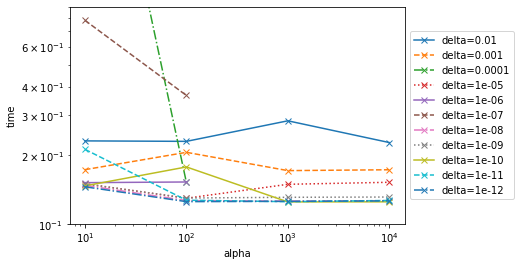

In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir

instances_size = 'house_instances'
results_dir = f'./output/mps1/{instances_size}'
# Read all json files in the results directory
file_names = [f for f in listdir(results_dir) if f.endswith('.json')]
instances = dict()
df_list = []
# instances_size=instances_size.replace('_1','')
for file in file_names:
    # if not "k0" in file:
        instance_name = file.split('.mps')[0]
        with open(f'{results_dir}/{file}', 'r') as f:
            data = json.load(f)

        # data to dataframe
        df = pd.DataFrame(data)

        # change "instance" column to name of file (last after /)
        df['instance'] = df['instance'].apply(lambda x: x.split('/')[-1]).apply(lambda x: x.replace('.mps', ''))
        
        # Time correction: If it has more than 1 row, and the -2 row has value "TERMINATION_REASON_TIME_LIMIT" on column "termination_reason", 
        # then remove the last row
        if len(df) > 1 and df.iloc[-2]['termination_reason'] == 'TERMINATION_REASON_TIME_LIMIT':
            # discount the blackbox_time of last row to the total_time column of every row
            df['total_time'] = df['total_time'] - df.iloc[-1]['blackbox_time']
            df = df.iloc[:-1]

        # KKT: norm of the three "relative" metrics
        df['KKT'] = np.sqrt(df['relative_l_inf_primal_residual']**2 + df['relative_l_inf_dual_residual']**2 + df['relative_optimality_gap']**2)    

        # success: if termination_reason of the last row is "TERMINATION_REASON_OPTIMAL", then success = 1, else 0
        df['success'] = 0
        if df.iloc[-1]['termination_reason'] == 'TERMINATION_REASON_OPTIMAL':
            df.loc[:, 'success'] = 1

        # IR: if 'max_iter' is 0, then it is a IR
        df['IR'] = 0
        if df.iloc[0]['max_iter'] > 0:
            df.loc[:, 'IR'] = 1

        # If it is not a IR, then set alpha to 0
        if df.iloc[0]['max_iter'] == 0:
            df['alpha'] = 0


        # Add the method of calculation of deltas from the name 
        if "median" in file:
            df['method'] = 'median'
        elif "reldiv_2" in file:
            df['method'] = 'reldiv_2'
        elif "reldiv" in file:
            df['method'] = 'reldiv'
        elif "relmult_2" in file:
            df['method'] = 'relmult_2'
        elif "relmult" in file:
            df['method'] = 'relmult'
        else:
            df['method'] = 'other'
        # elif "rel" in file:

        # Add the delta of housing problem
        # print(instance_name)
        delta = float(instance_name.replace('house_k5_d',''))
        if delta == 0.1:
            continue
        # Save delta in the dataframe, but change format to scientific notation
        df['delta'] = delta
        # df['delta'] = df['delta'].apply(lambda x: '{:.1e}'.format(x))

        # add to list
        for row in df.iterrows():
            # print(row[2])
            # row = row[1]
            # row series to list
            row = row[1].tolist()
            df_list.append(pd.DataFrame([row], columns=df.columns))

# Concatenate all dataframes
df = pd.concat(df_list)
# Change column names
col_names_dict = {
    'last_iteration': 'k_iters',
    'total_time': 'time',
    'D1_condition_number': 'D1_maxcn',
    'D2_condition_number': 'D2_maxcn',
}
df.rename(columns=col_names_dict, inplace=True)

# display(df.sample(10))
# Sort by instance, alpha and max_iter
# df.sort_values(by=['instance'], inplace=True)
# Group by instance, alpha and max_iter
grouped = df.groupby(['delta','instance', 'IR', 'alpha'])
# columns to get the min value
tail_cols = ['KKT', 'success', 'time', 'k_iters']
# columns to get the max value
max_cols = ['D1_maxcn', 'D2_maxcn']
grouped = grouped.agg({**{col: 'min' for col in tail_cols}, **{col: 'max' for col in max_cols}})


# Sorty by delta
grouped = grouped.sort_values(by=['delta'], ascending=False)
# Round to 3 decimals time, and condition numbers columns
# grouped['time'] = grouped['time'].apply(lambda x: round(x, 3))
# grouped['D1_maxcn'] = grouped['D1_maxcn'].apply(lambda x: round(x, 3))
# grouped['D2_maxcn'] = grouped['D2_maxcn'].apply(lambda x: round(x, 3))

# i0 = 15
# display(grouped.iloc[i0:i0+21,:])


# Plot the time of the instances in terms of alpha
ax, fig = plt.subplots()
grouped = grouped.reset_index()

# Split the dataframe by k_iters
grouped_k1 = grouped[grouped['k_iters'] == 1]
grouped_k0 = grouped[grouped['k_iters'] == 0]

line_styles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.', ':']
for i,delta in enumerate(grouped_k1['delta'].unique()):
    # for alpha in grouped_k1['alpha'].unique():
        # df_plot = grouped_k1[(grouped_k1['delta'] == delta) & (grouped_k1['alpha'] == alpha)]
    df_plot = grouped_k1[(grouped_k1['delta'] == delta)]

    if delta < 0.1 and delta > 0.001:
        delta = round(delta, 3)

    # Sort by alpha
    df_plot = df_plot.sort_values(by=['alpha'], ascending=True)

    # Plot time vs alpha, with log(alpha)
    plt.plot(df_plot['alpha'], df_plot['time'], label=f'delta={delta}', linestyle=line_styles[i], marker='x')
    # double log scale for y
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('alpha')
    plt.ylabel('time')

# legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.legend()
plt.ylim(1e-1, 0.9)
plt.show()


    # plt.plot(df_plot['alpha'], df_plot['time'], label=f'delta={delta}, alpha={alpha}')

# Save grouped_k1 dataframe to csv
# grouped.to_csv(f'MIPLIB_output/batch_output/{instances_size}_600.csv')


c:\Users\niace\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,delta,instance,IR,alpha,KKT,success,time,k_iters,D1_maxcn,D2_maxcn
4,1.000000e-02,house_k5_d0.010000000000000002,0,0.01,2.867510e-11,1,18.473639,0,1.0,1.0
9,1.000000e-03,house_k5_d0.001,0,0.00,1.354117e-15,1,0.257789,0,1.0,1.0
24,1.000000e-07,house_k5_d1.0e-7,0,0.00,NaN,0,616.749320,0,1.0,1.0
28,1.000000e-08,house_k5_d1.0e-8,0,0.00,1.350045e-09,1,18.349054,0,1.0,1.0
34,1.000000e-09,house_k5_d1.0e-9,0,0.00,1.350046e-10,1,18.486040,0,1.0,1.0
37,1.000000e-10,house_k5_d1.0e-10,0,0.00,1.350031e-11,1,0.019463,0,1.0,1.0
44,1.000000e-11,house_k5_d1.0e-11,0,0.00,1.349747e-12,1,0.019666,0,1.0,1.0
49,1.000000e-12,house_k5_d1.0e-12,0,0.00,1.349706e-13,1,0.019339,0,1.0,1.0


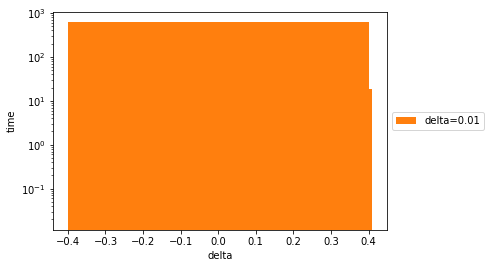

In [57]:

line_styles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.', ':']

grouped_k0.loc[grouped_k0['delta'] ==0.010000000000000002, 'alpha'] = 0.01

# # for i,delta in enumerate(grouped_k0['delta'].unique()):
#     # for alpha in grouped_k0['alpha'].unique():
#         # df_plot = grouped_k0[(grouped_k0['delta'] == delta) & (grouped_k0['alpha'] == alpha)]
#     df_plot = grouped_k0[(grouped_k0['delta'] == delta)]

#     if delta < 0.1 and delta > 0.001:
df_plot = grouped_k0
display(df_plot)
# Sort by alpha
df_plot = df_plot.sort_values(by=['alpha'], ascending=True)

# Plot time vs alpha, with log(alpha)
# uniform spaced barplot of time vs delta
plt.bar(df_plot['alpha'], df_plot['time'])
plt.bar(df_plot['delta'], df_plot['time'], label=f'delta={delta}')
# double log scale for y
plt.yscale('log')
# plt.xscale('log')
plt.xlabel('delta')
plt.ylabel('time')

# legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.legend()
# plt.ylim(1e-1, 0.9)
plt.show()



In [77]:
import numpy as np

# Generate a randon normal vector of mean 0 and std 1
x = np.random.normal(0, 1, 100) +10

# Print the vector
# print(x)

# Get the average of the vector, the std and the geometric mean
mean = np.mean(x)
std = np.std(x)
# Print the results
print(f"Mean: {mean}")
print(f"Std: {std}")
for delta in [10]:
    sgm = np.prod(x+ delta)**(1/len(x)) - delta
    print(f"SGM: {sgm}")
# gmean = np.exp(np.mean(np.log(np.abs(x))))


# print(f"Geometric mean: {gmean}")

Mean: 9.655670909939364
Std: 1.0099906141214892
SGM: 9.629649919256291


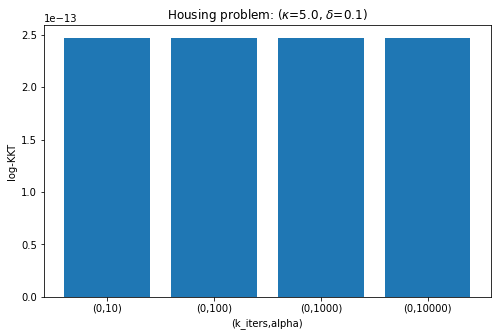

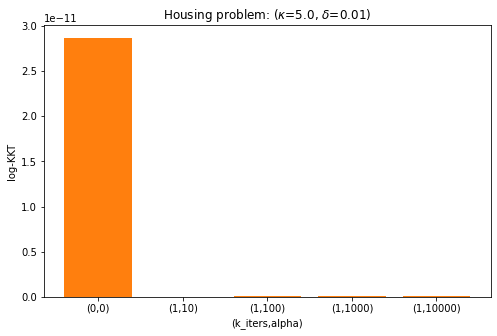

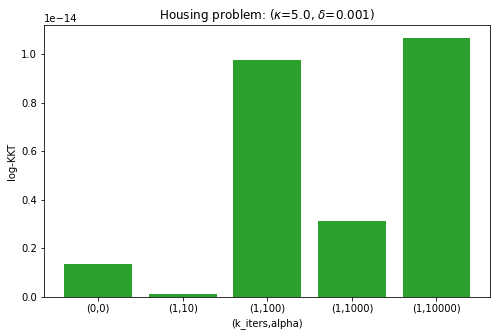

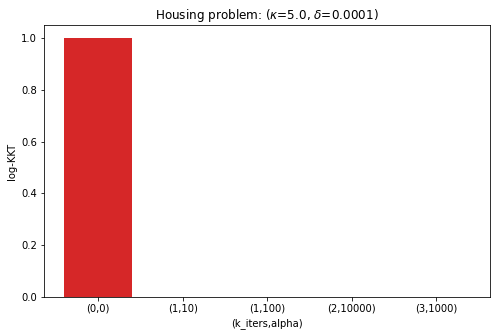

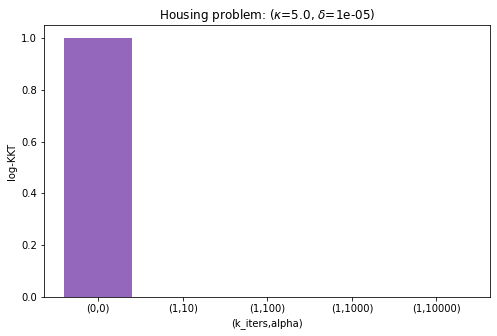

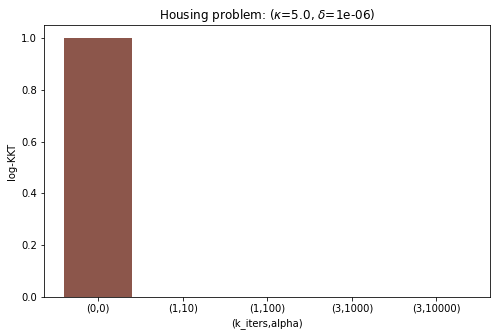

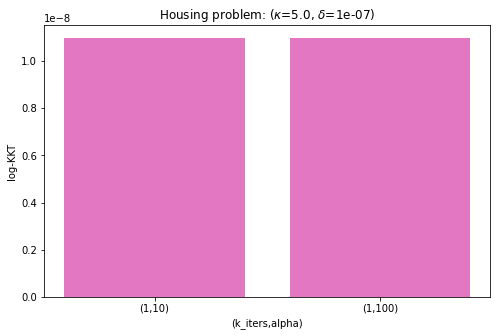

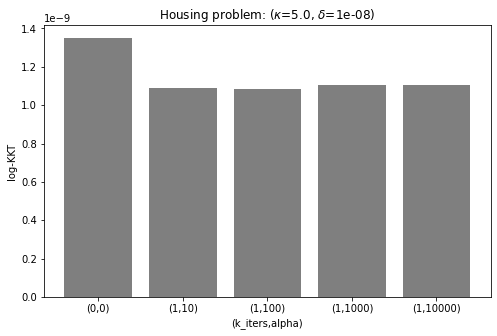

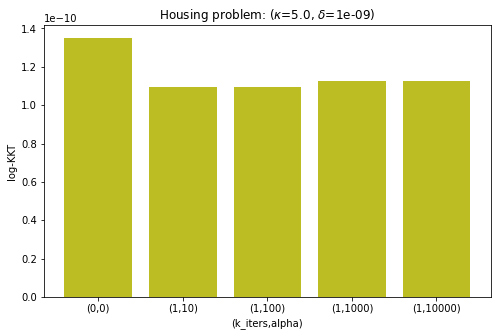

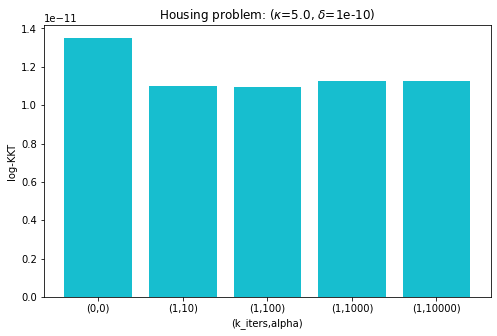

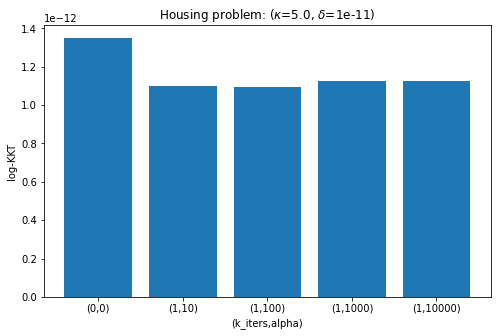

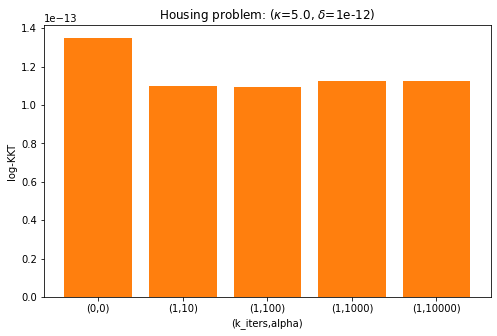

In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir

instances_size = 'house_instances'
results_dir = f'./output/mps1/{instances_size}'
# Read all json files in the results directory
file_names = [f for f in listdir(results_dir) if f.endswith('.json')]
instances = dict()
df_list = []
# instances_size=instances_size.replace('_1','')
for file in file_names:
    # if not "k0" in file:
        instance_name = file.split('.mps')[0]
        kappa = float(instance_name.split('_')[1].replace('k',''))
        delta = float(instance_name.split('_')[2].replace('d',''))
        if delta == 0.010000000000000002:
            delta = 0.01
        # print(instance_name, kappa, delta)
        # continue
        with open(f'{results_dir}/{file}', 'r') as f:
            data = json.load(f)

        # data to dataframe
        df = pd.DataFrame(data)

        # change "instance" column to name of file (last after /)
        df['instance'] = df['instance'].apply(lambda x: x.split('/')[-1]).apply(lambda x: x.replace('.mps', ''))
        
        # Time correction: If it has more than 1 row, and the -2 row has value "TERMINATION_REASON_TIME_LIMIT" on column "termination_reason", 
        # then remove the last row
        if len(df) > 1 and df.iloc[-2]['termination_reason'] == 'TERMINATION_REASON_TIME_LIMIT':
            # discount the blackbox_time of last row to the total_time column of every row
            df['total_time'] = df['total_time'] - df.iloc[-1]['blackbox_time']
            df = df.iloc[:-1]

        # KKT: norm of the three "relative" metrics
        df['KKT'] = np.sqrt(df['relative_l_inf_primal_residual']**2 + df['relative_l_inf_dual_residual']**2 + df['relative_optimality_gap']**2)    

        # success: if termination_reason of the last row is "TERMINATION_REASON_OPTIMAL", then success = 1, else 0
        df['success'] = 0
        if df.iloc[-1]['termination_reason'] == 'TERMINATION_REASON_OPTIMAL':
            df.loc[:, 'success'] = 1

        # IR: if 'max_iter' is 0, then it is a IR
        df['IR'] = 0
        if df.iloc[0]['max_iter'] > 0:
            df.loc[:, 'IR'] = 1

        # If it is not a IR, then set alpha to 0
        if df.iloc[0]['max_iter'] == 0:
            df['alpha'] = 0


        # Add the method of calculation of deltas from the name 
        if "median" in file:
            df['method'] = 'median'
        elif "reldiv_2" in file:
            df['method'] = 'reldiv_2'
        elif "reldiv" in file:
            df['method'] = 'reldiv'
        elif "relmult_2" in file:
            df['method'] = 'relmult_2'
        elif "relmult" in file:
            df['method'] = 'relmult'
        else:
            df['method'] = 'other'
        # elif "rel" in file:

        # Add the delta of housing problem
        # print(instance_name)
        # delta = float(instance_name.replace('house_k5_d',''))
        # if delta == 0.1:
        #     continue
        # Save delta in the dataframe, but change format to scientific notation
 
        df['delta'] = delta
        df['kappa'] = kappa
        # df['delta'] = df['delta'].apply(lambda x: '{:.1e}'.format(x))

        # add to list
        for row in df.iterrows():
            # print(row[2])
            # row = row[1]
            # row series to list
            row = row[1].tolist()
            df_list.append(pd.DataFrame([row], columns=df.columns))

# Concatenate all dataframes
df = pd.concat(df_list)
# Change column names
col_names_dict = {
    'last_iteration': 'k_iters',
    'total_time': 'time',
    'D1_condition_number': 'D1_maxcn',
    'D2_condition_number': 'D2_maxcn',
}
df.rename(columns=col_names_dict, inplace=True)

# display(df.sample(10))
# Sort by instance, alpha and max_iter
# df.sort_values(by=['instance'], inplace=True)
# Group by instance, alpha and max_iter
grouped = df.groupby(['instance', 'IR', 'alpha', 'delta', 'kappa'])
# columns to get the min value
tail_cols = ['KKT', 'success', 'time', 'k_iters']
# columns to get the max value
max_cols = ['D1_maxcn', 'D2_maxcn']
grouped = grouped.agg({**{col: 'min' for col in tail_cols}, **{col: 'max' for col in max_cols}})


# Sorty by delta
grouped = grouped.sort_values(by=['kappa','delta'], ascending=False)
# Round to 3 decimals time, and condition numbers columns
# grouped['time'] = grouped['time'].apply(lambda x: round(x, 3))
# grouped['D1_maxcn'] = grouped['D1_maxcn'].apply(lambda x: round(x, 3))
# grouped['D2_maxcn'] = grouped['D2_maxcn'].apply(lambda x: round(x, 3))

# i0 = 15
# display(grouped.iloc[i0:i0+21,:])


# Plot the time of the instances in terms of alpha
grouped = grouped.reset_index()

# Split the dataframe by k_iters
# grouped = grouped[grouped['k_iters'] == 1]
# grouped_k0 = grouped[grouped['k_iters'] == 0]

line_styles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.', ':']
for j,kappa in enumerate(grouped['kappa'].unique()):
    for i,delta in enumerate(grouped['delta'].unique()):
        # if delta == 0.1:
        #     continue
        ax, fig = plt.subplots(figsize=(8, 5))
        # for alpha in grouped['alpha'].unique():
        df_plot = grouped[(grouped['delta'] == delta) & (grouped['kappa'] == kappa)]
        # df_plot = grouped[(grouped['delta'] == delta)]

        # Sort by alpha
        df_plot = df_plot.sort_values(by=['k_iters','alpha'], ascending=True)

        # # # Alpha column to a string in scientific notation for alpha > 10
        # df_plot['alpha'] = df_plot['alpha'].apply(lambda x: '{:.1e}'.format(x) if x > 10 else x)

        # Create a new column with the tuple (k_iters, alpha)
        df_plot['k_alpha'] = '('+df_plot['k_iters'].astype(str) + ',' + df_plot['alpha'].astype(int).astype(str)+')'

        # If (0,0) is not in the dataframe, then add it with time = 600, at the beginning of the dataframe
        if not ('(0,0)' in df_plot['k_alpha'].values) and delta != 0.1:
            df_plot = pd.concat([pd.DataFrame({'k_alpha': ['(0,0)'], 'time': [600]}), df_plot])
            df_plot = pd.concat([pd.DataFrame({'k_alpha': ['(0,0)'], 'KKT': [1]}), df_plot])

        # Add 1 to KKT
        # df_plot['KKT_1'] = df_plot['KKT'] + 1

        # Plot time vs alpha, with log(alpha)
        plt.bar(df_plot['k_alpha'], df_plot['KKT'], color='C'+str(i))
        # plt.plot(df_plot['k_alpha'], df_plot['KKT'], label=f'delta={delta}', linestyle=line_styles[i], marker='x')
        # double log scale for y
        # plt.yscale('log')
        # plt.xscale('log')
        plt.xlabel('(k_iters,alpha)')
        plt.ylabel('log-KKT')
        plt.title(fr'Housing problem: ($\kappa$={kappa}, $\delta$={delta})')

        # legend outside the plot
        # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        # plt.legend() 
        # plt.ylim(1e-1, 0.9)
        plt.show()

# Save grouped dataframe to csv
# grouped.to_csv(f'MIPLIB_output/batch_output/{instances_size}_600.csv')
